In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
import os
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [3]:
import os
os.getcwd()

'C:\\Users\\ankan\\Desktop\\Amazon Apparel'

In [4]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [5]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'has', 'yourselves', 'above', "you'd", 'such', 'that', 'she', 'some', 'does', 'i', 'won', 'weren', 'off', 'if', 'into', 'it', 'no', 'why', 'had', 'further', 'y', 'few', 'most', 'will', 'ma', 'his', 'ours', 'more', 'o', 'once', "wasn't", 'during', "should've", 'couldn', "mustn't", 'didn', 'my', 'their', 'theirs', 'needn', "you're", 's', 'here', 'these', 'just', 'than', "couldn't", 'before', 'doing', 'her', 'an', 'same', 'at', 'hadn', 'mightn', 'wouldn', 'what', "didn't", 'they', 'can', 'aren', 'then', 'them', 'which', 'very', 'am', 'have', 'as', 'whom', 'all', 'shouldn', "wouldn't", 'to', 'you', "doesn't", 'wasn', "weren't", 'while', 'yours', 'll', 'other', 'over', 'd', 'isn', 'not', "you'll", 'your', "haven't", 'for', 'hers', 'were', 'against', "mightn't", 'the', 'of', 'its', 'or', 'where', "needn't", 'because', 'there', "isn't", "she's", "don't", 'when', "hadn't", 'being', 'is', 'me', 'did', 'our', 'shan', 'each', 'again', "shouldn't", 're', "it's", 'who', 'mustn'

In [6]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

4.5441406 seconds


In [7]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [8]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [9]:
start_time = time.clock()

# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        
print(time.clock() - start_time, "seconds")

168.3267193 seconds


In [10]:
#reading the saved file of word2vec
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [11]:
vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [12]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [13]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

In [14]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )


# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)
#type_vectorizer = CountVectorizer()
#type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = ((brand_features)).tocsr()
extra_features1 = ((color_features)).tocsr()
extra_features2 = ((type_features)).tocsr()

In [15]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [16]:
# Utility functions
#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

#img = PIL.Image.open(fp)
def get_word_vec(sentence, doc_id, m_name):
   
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [17]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,10))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6),linewidths=.5, annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [18]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

In [19]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
import PIL.Image

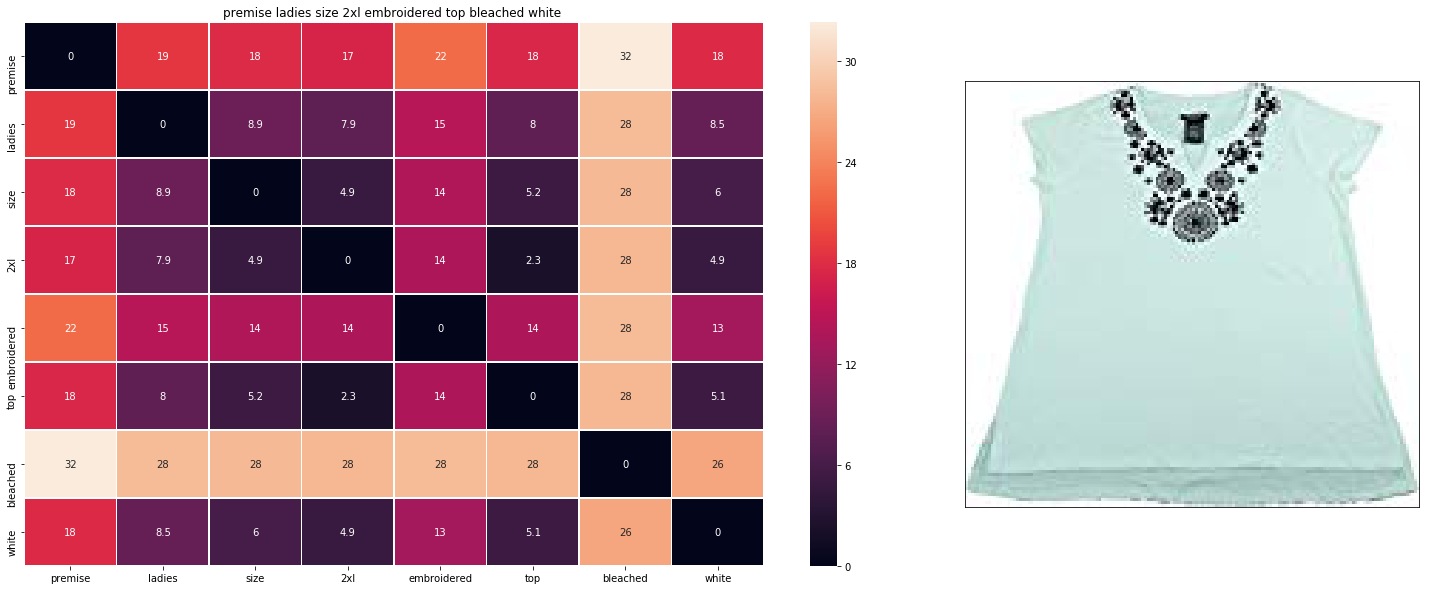

ASIN of the product : B01M0IDUCV
Brand of the product : Premise
Title of the product : premise ladies size 2xl embroidered top bleached white 
Type of the product : SHIRT
Euclidean distance from input : 0.01262690680367606


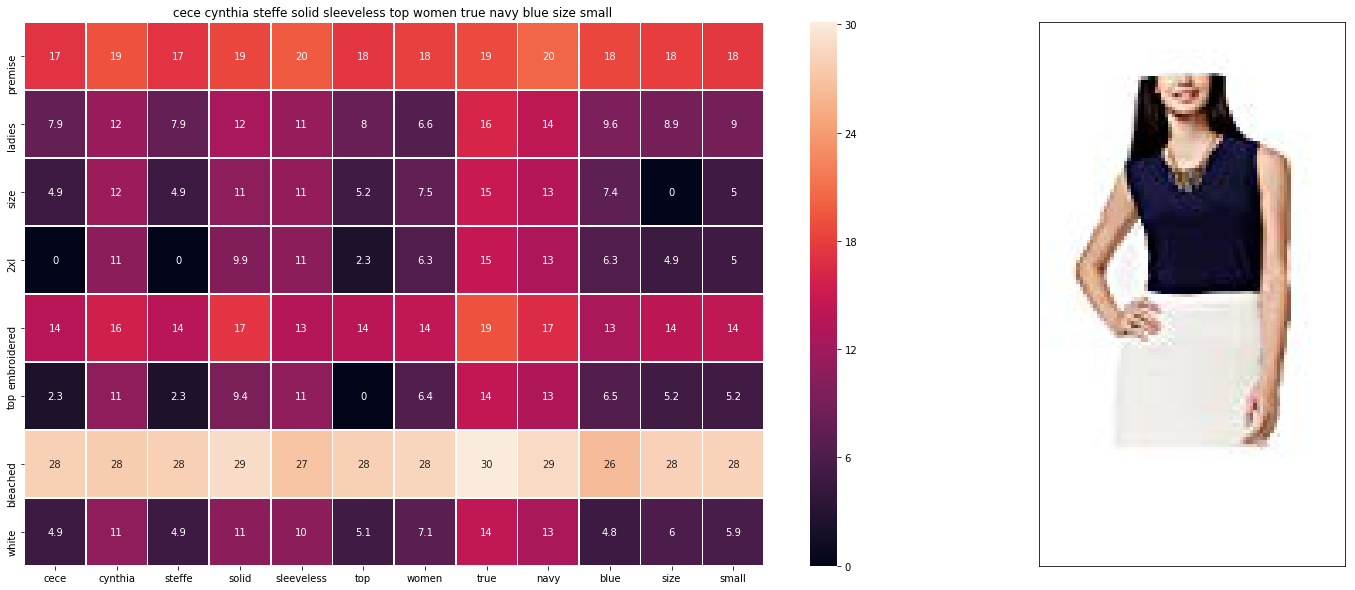

ASIN of the product : B01N4NQ7LX
Brand of the product : CeCe by Cynthia Steffe
Title of the product : cece cynthia steffe solid sleeveless top women true navy blue size small 
Type of the product : SHIRT
Euclidean distance from input : 10.105387684355438


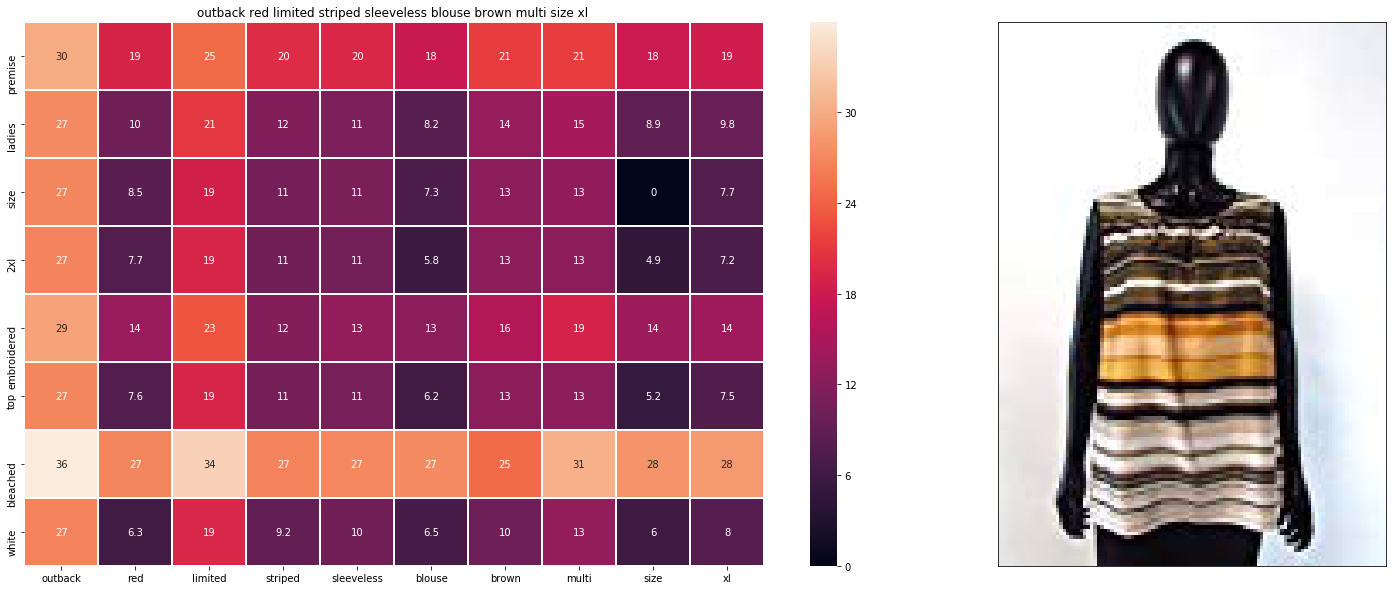

ASIN of the product : B01IU645VU
Brand of the product : Outback Red
Title of the product : outback red limited striped sleeveless blouse brown multi size xl 
Type of the product : SHIRT
Euclidean distance from input : 13.380004189027698


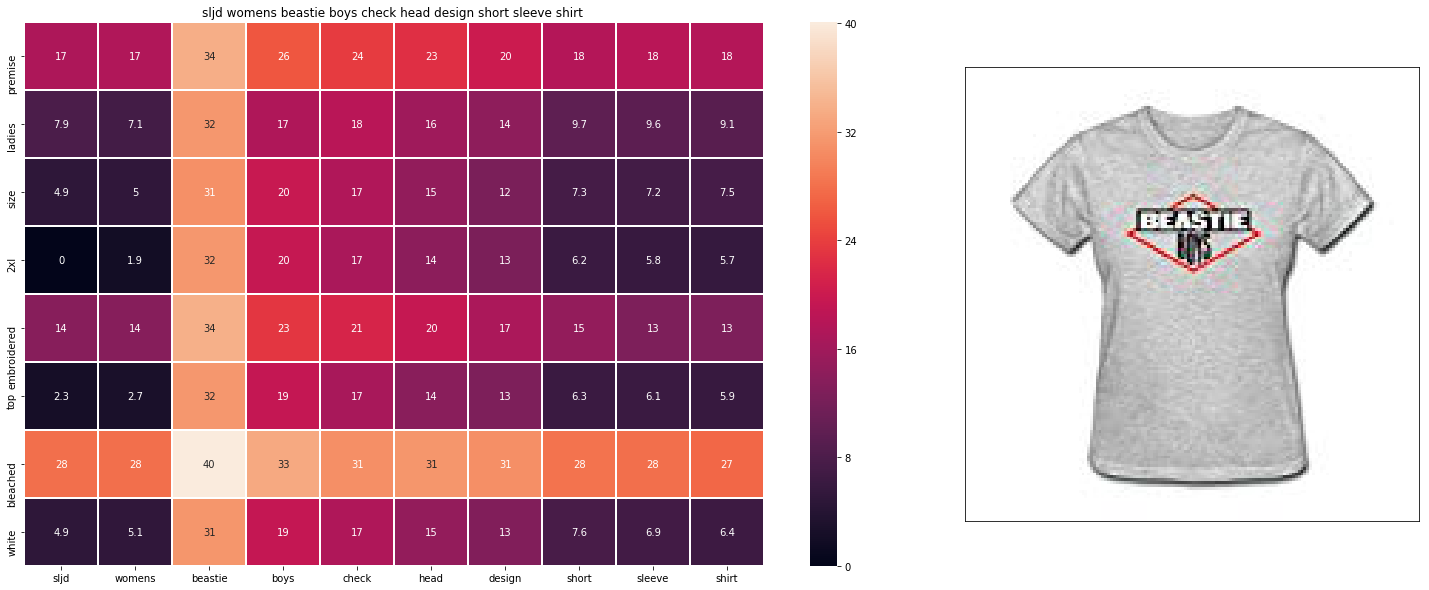

ASIN of the product : B01FQLKKMK
Brand of the product : SLJD
Title of the product : sljd womens beastie boys check head design short sleeve shirt 
Type of the product : BOOKS_1973_AND_LATER
Euclidean distance from input : 14.365294284269135


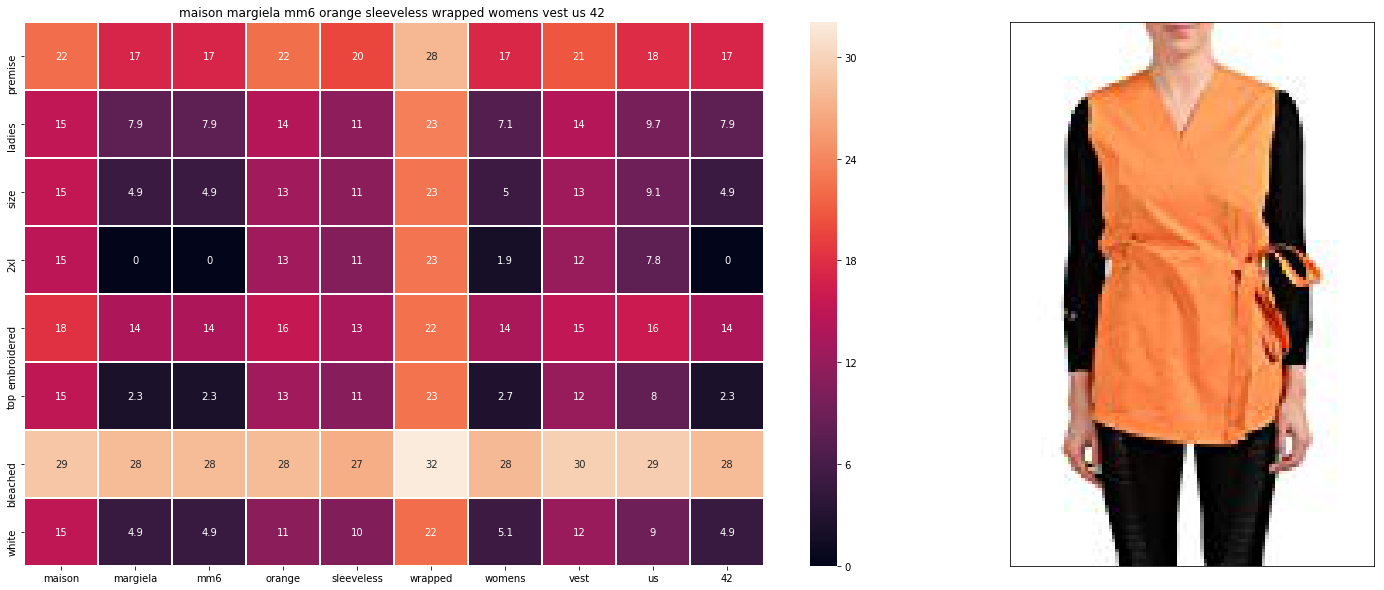

ASIN of the product : B01MXI5L4G
Brand of the product : Maison Margiela MM6
Title of the product : maison margiela mm6 orange sleeveless wrapped womens vest us 42 
Type of the product : SHIRT
Euclidean distance from input : 15.01023695471555


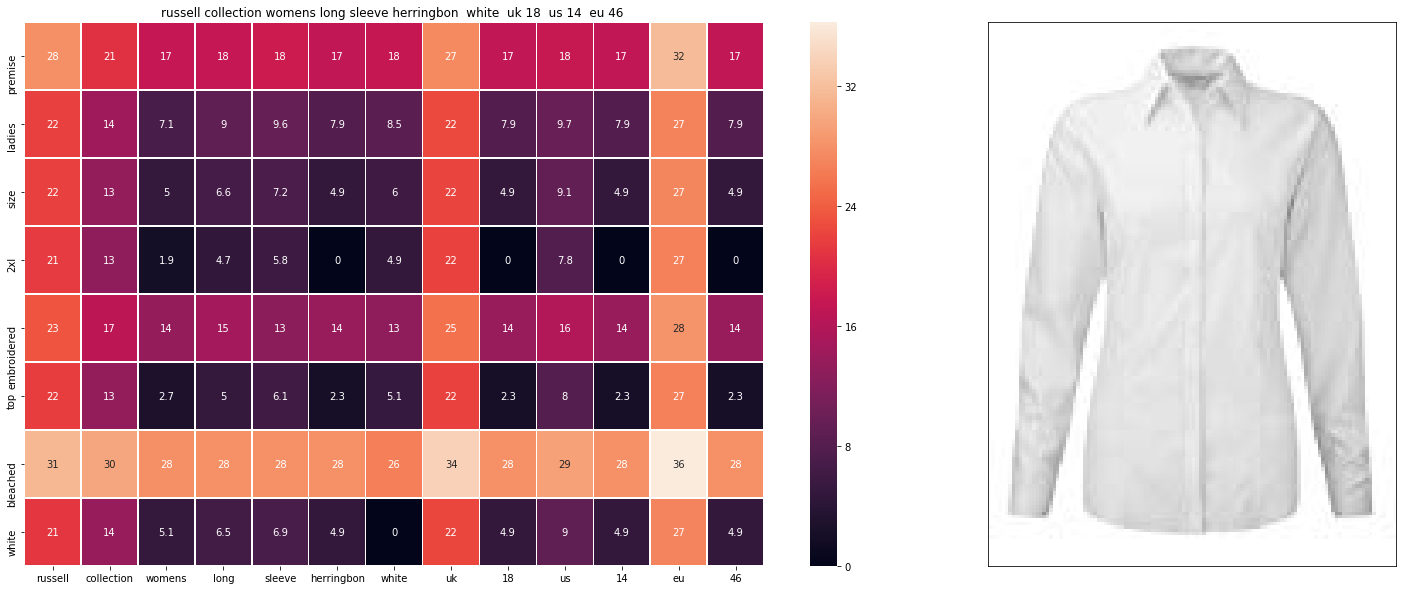

ASIN of the product : B00K77AN5S
Brand of the product : Russell Collection
Title of the product : russell collection womens long sleeve herringbon  white  uk 18  us 14  eu 46 
Type of the product : SHIRT
Euclidean distance from input : 15.04065177203551


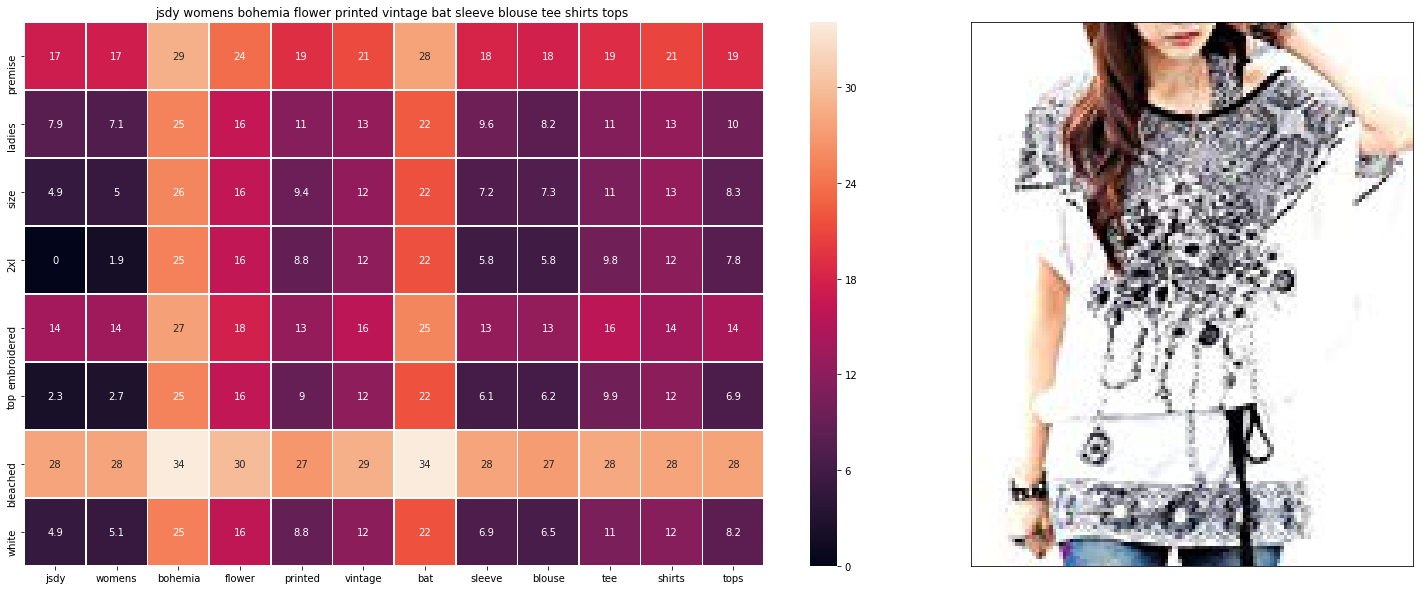

ASIN of the product : B00L8RE3PC
Brand of the product : JSDY-Cloth
Title of the product : jsdy womens bohemia flower printed vintage bat sleeve blouse tee shirts tops 
Type of the product : SHIRT
Euclidean distance from input : 15.043643628201805


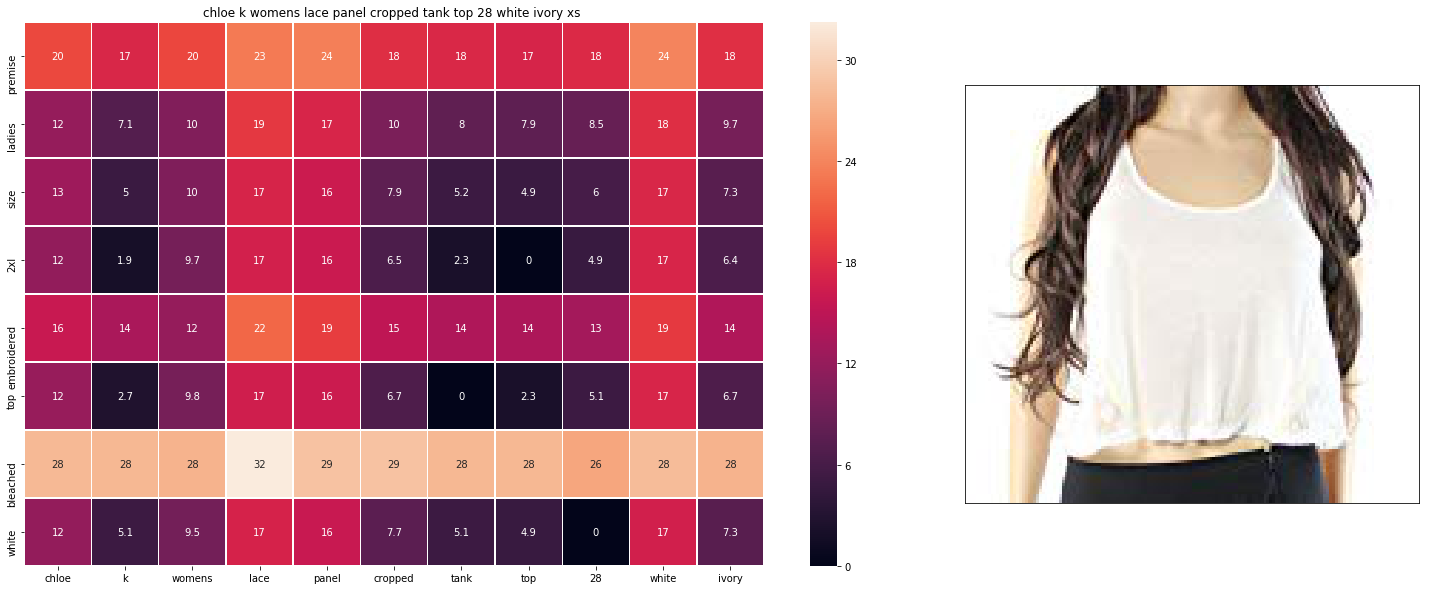

ASIN of the product : B071VZCT5W
Brand of the product : Chloe K.
Title of the product : chloe k womens lace panel cropped tank top 28 white ivory xs 
Type of the product : SHIRT
Euclidean distance from input : 15.097135663868604


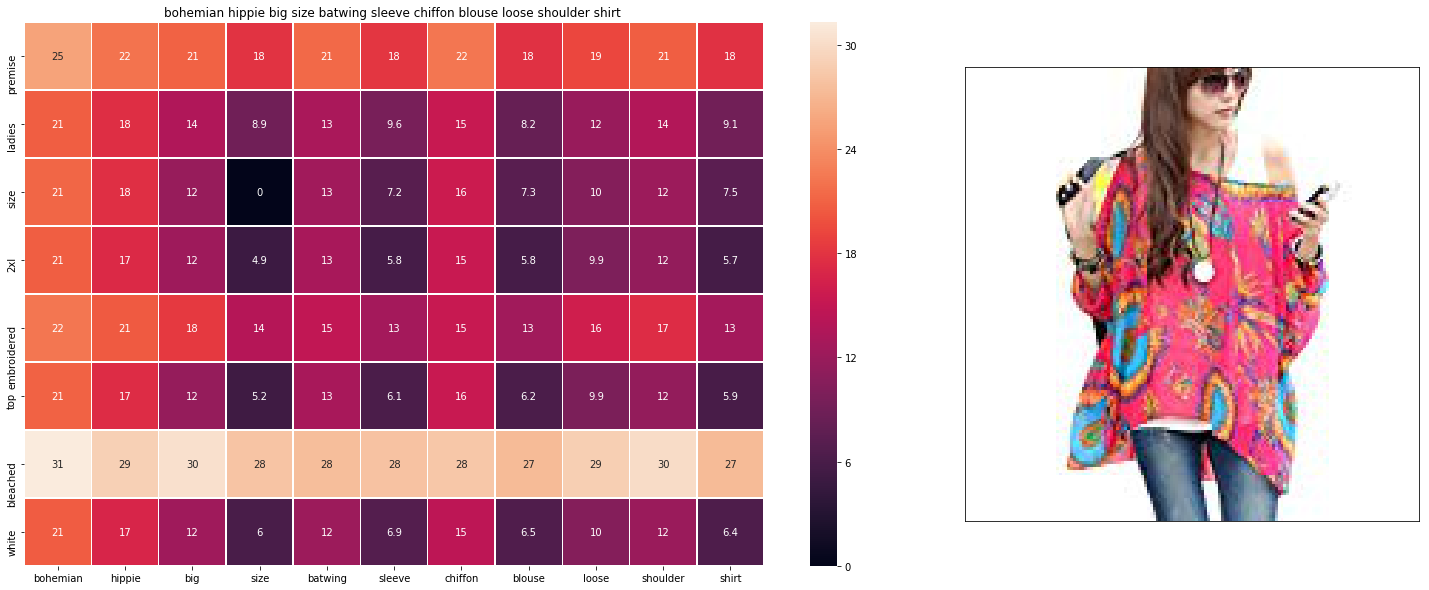

ASIN of the product : B00YC92VRU
Brand of the product : Display Promotion
Title of the product : bohemian hippie big size batwing sleeve chiffon blouse loose shoulder shirt 
Type of the product : SHIRT
Euclidean distance from input : 15.185014826686752


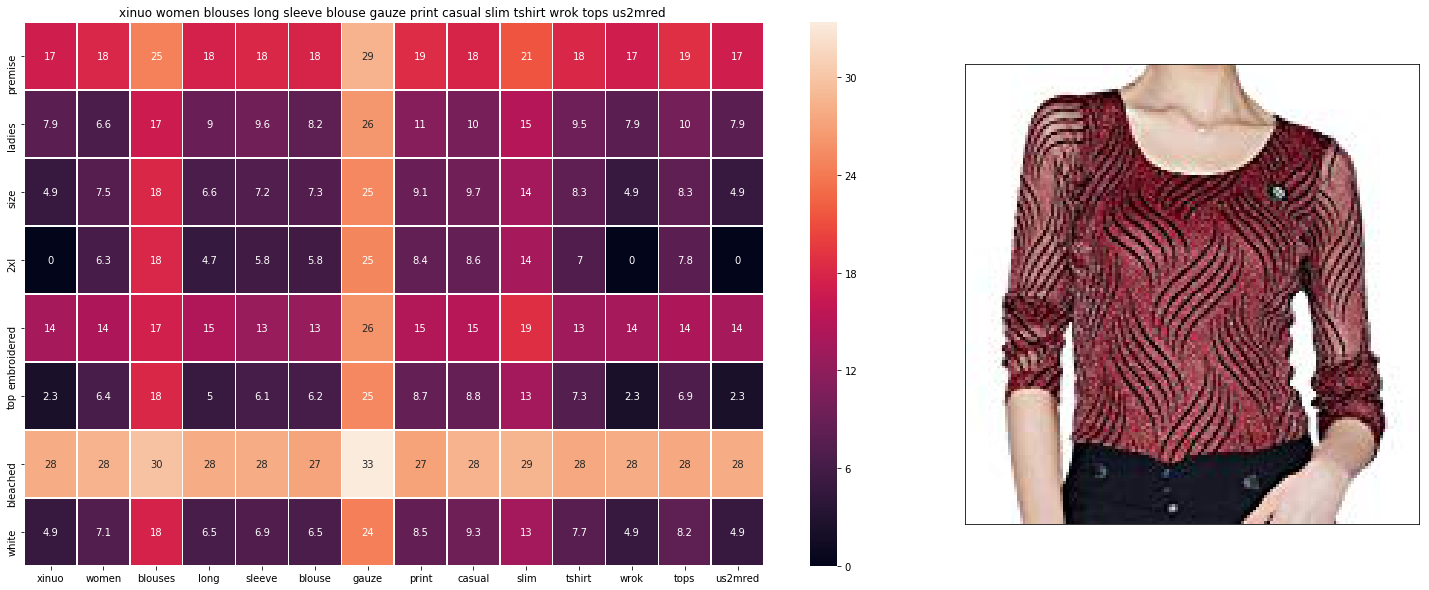

ASIN of the product : B01MU874KK
Brand of the product : XINUO
Title of the product : xinuo women blouses long sleeve blouse gauze print casual slim tshirt wrok tops us2mred 
Type of the product : SHIRT
Euclidean distance from input : 15.254732935166171


In [20]:
def get_similar_products_cnn(doc_id, w1, w2, w3, w4, w5, num_results):
    doc_id = asins.index(df_asins[doc_id])
    title = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand  = pairwise_distances(extra_features, extra_features[doc_id])
    color = pairwise_distances(extra_features1, extra_features1[doc_id])
    image = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    types = pairwise_distances(extra_features2, extra_features2[doc_id])
    pairwise_dist = (w1 * title[0:16042] +  w2 * brand[0:16042] + w3 * image + w4*color[0:16042] + w5 * types[0:16042])/float(w1 + w2 + w3 + w4 + w5)


    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN of the product :',data['asin'].loc[df_indices[i]])
        print('Brand of the product :',data['brand'].loc[df_indices[i]])
        print('Title of the product :',data['title'].loc[df_indices[i]])
        print('Type of the product :',data['product_type_name'].loc[df_indices[i]])
        print('Euclidean distance from input :', pdists[i])
        print('='*242)
get_similar_products_cnn(12566, 50, 50, 100, 100, 50,  10) #giving more weights to the images and the color features

# what weight is what...??...



<table style="width:100%">
  <tr>
     <th> SR </th>
    <th>Weight of</th>
    <th>Nomenclature</th>
      
      
</tr>
  <tr>
    <td> 1. </td>
    <td>Title</td>
    <td>W1</td>
  <tr>
    <tr>
     <td> 2. </td>
    <td>Brand</td>
    <td>W2</td>
  <tr>
  <tr>
     <td> 3. </td>
    <td>Image</td>
    <td>W3</td>
  <tr>
    <tr>
      <td> 4. </td>
    <td>color</td>
    <td>W4</td>
  <tr>
   <tr>
    <tr>
      <td> 5. </td>
    <td>Type</td>
    <td>W5</td>
  <tr>
</tr>
</table> 


__Giving more weight to the Title__

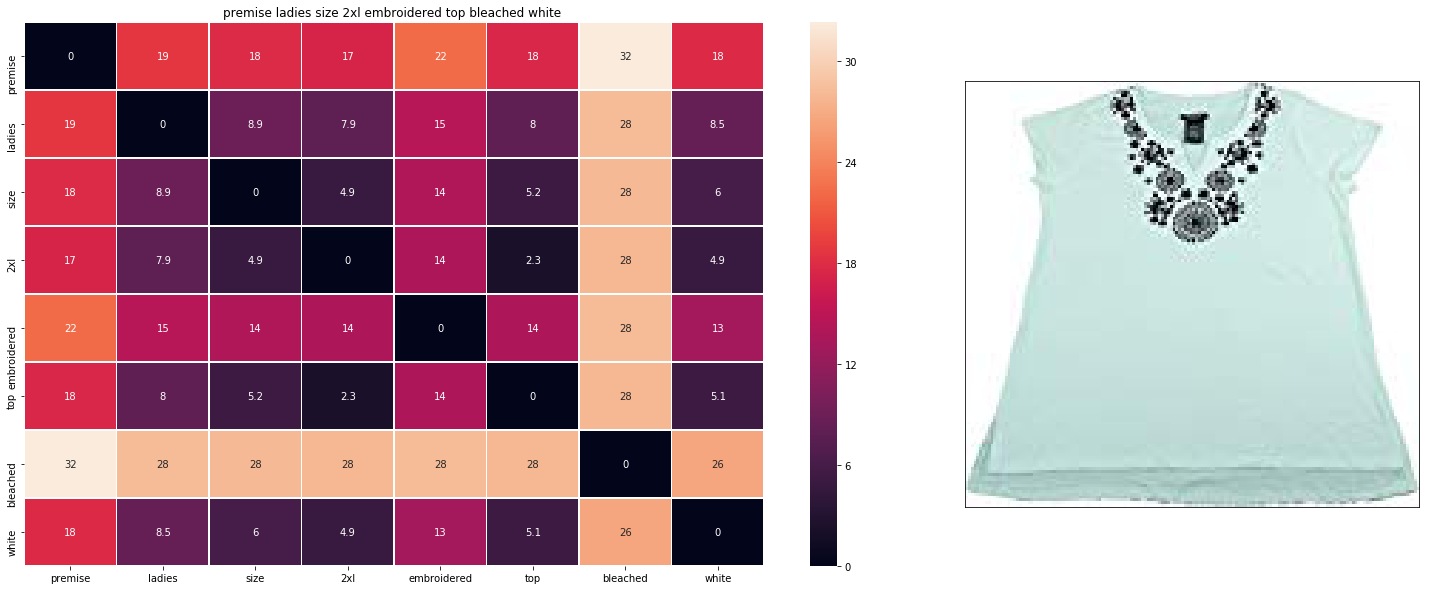

ASIN of the product : B01M0IDUCV
Brand of the product : Premise
Title of the product : premise ladies size 2xl embroidered top bleached white 
Type of the product : SHIRT
Euclidean distance from input : 0.0


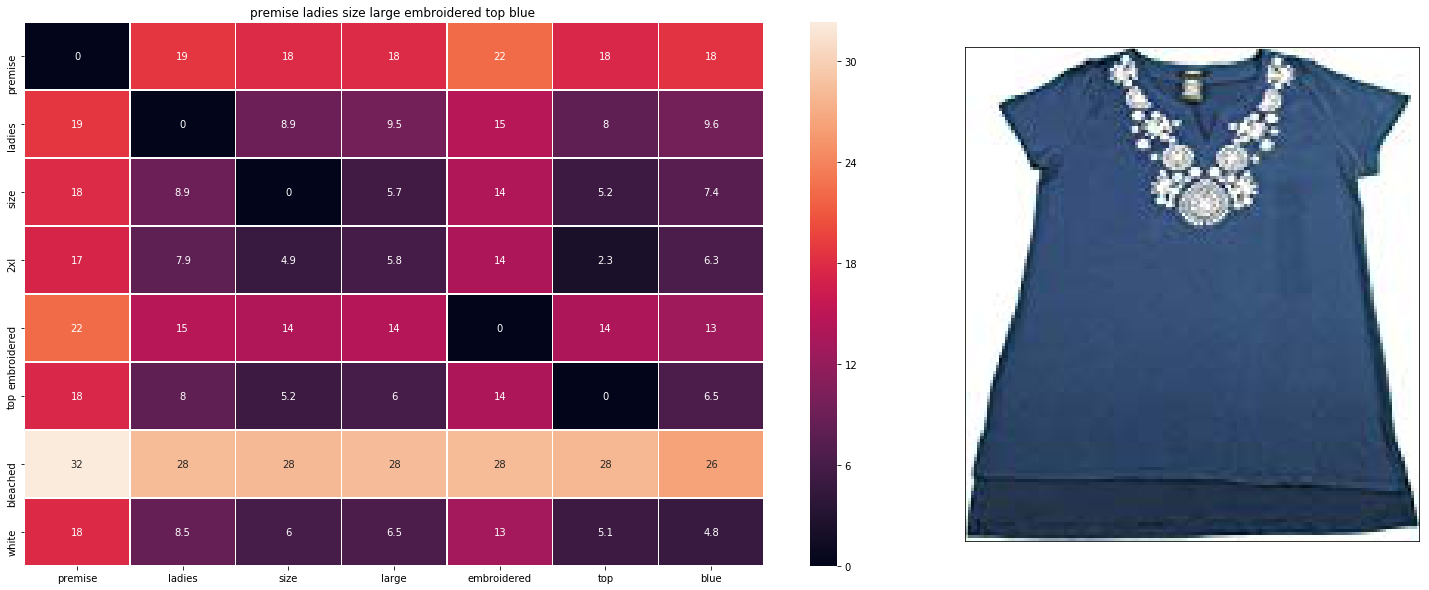

ASIN of the product : B01LFDIDBS
Brand of the product : Premise
Title of the product : premise ladies size large embroidered top blue 
Type of the product : SHIRT
Euclidean distance from input : 3.4931259155273438


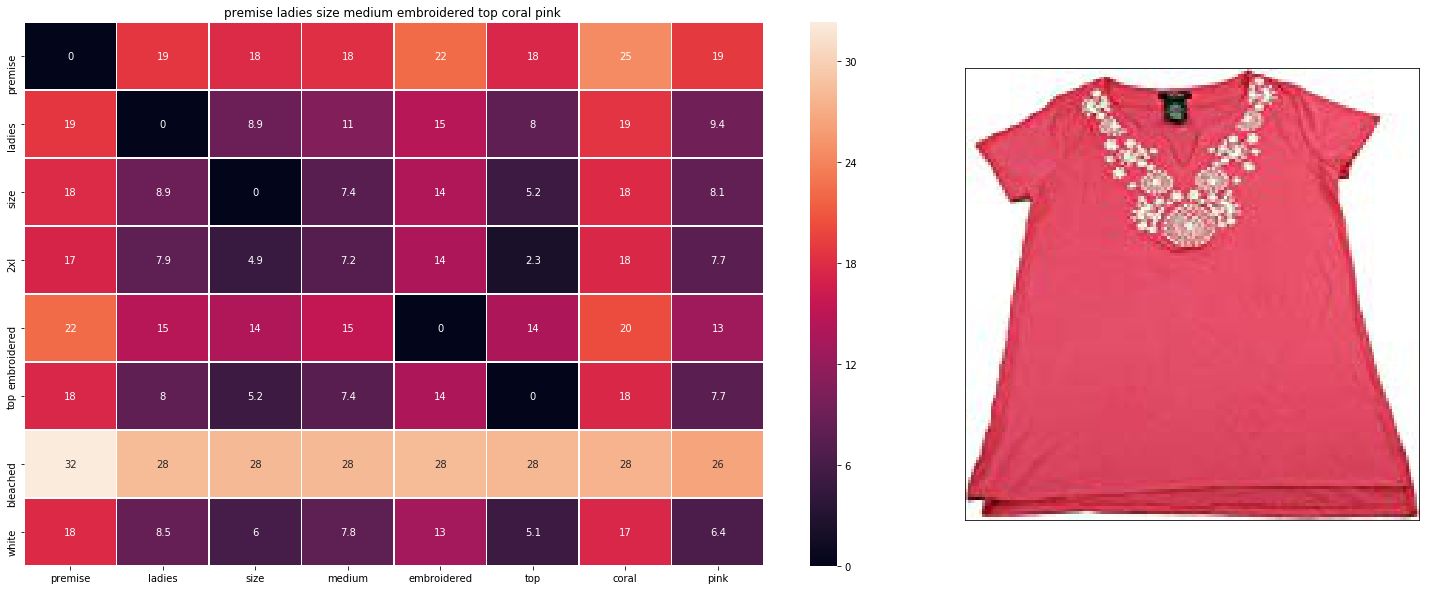

ASIN of the product : B01LWUIZYJ
Brand of the product : Premise
Title of the product : premise ladies size medium embroidered top coral pink 
Type of the product : SHIRT
Euclidean distance from input : 3.6303692626953126


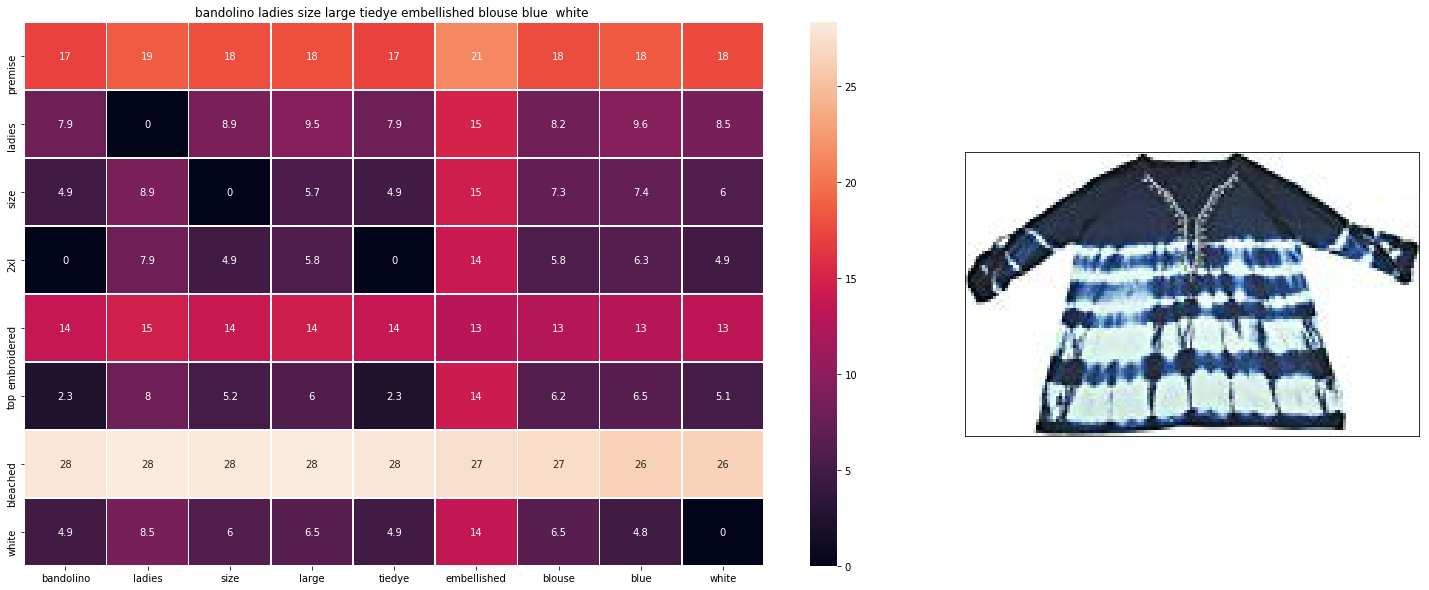

ASIN of the product : B01KP7KZI4
Brand of the product : Bandolino
Title of the product : bandolino ladies size large tiedye embellished blouse blue  white 
Type of the product : SHIRT
Euclidean distance from input : 4.084248046875


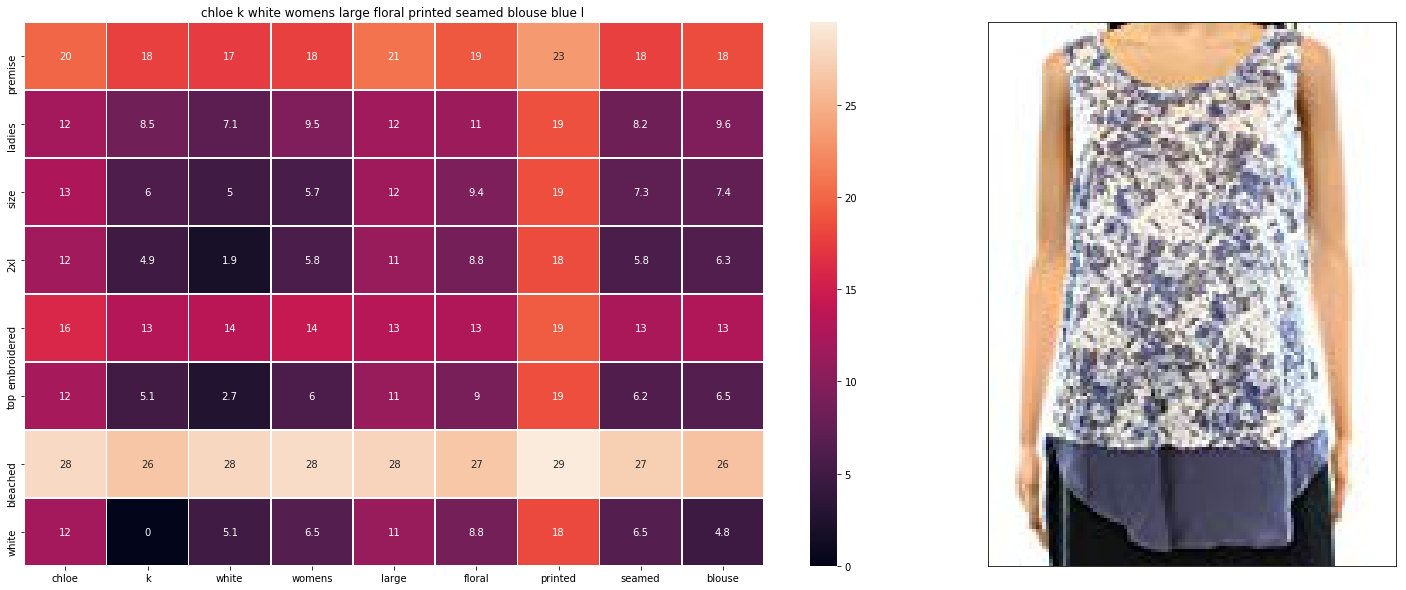

ASIN of the product : B074P8RKKB
Brand of the product : Chloe K.
Title of the product : chloe k white womens large floral printed seamed blouse blue l 
Type of the product : SHIRT
Euclidean distance from input : 4.1357666015625


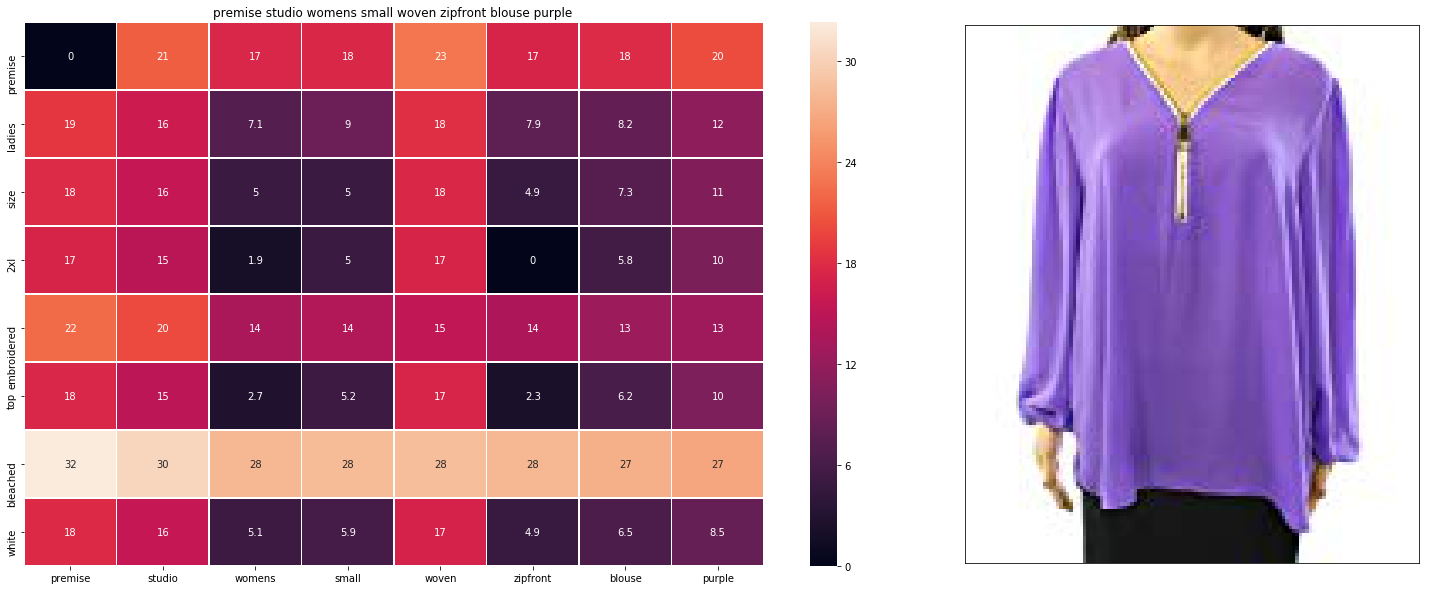

ASIN of the product : B074P923YD
Brand of the product : Premise Studio
Title of the product : premise studio womens small woven zipfront blouse purple 
Type of the product : SHIRT
Euclidean distance from input : 4.14260498046875


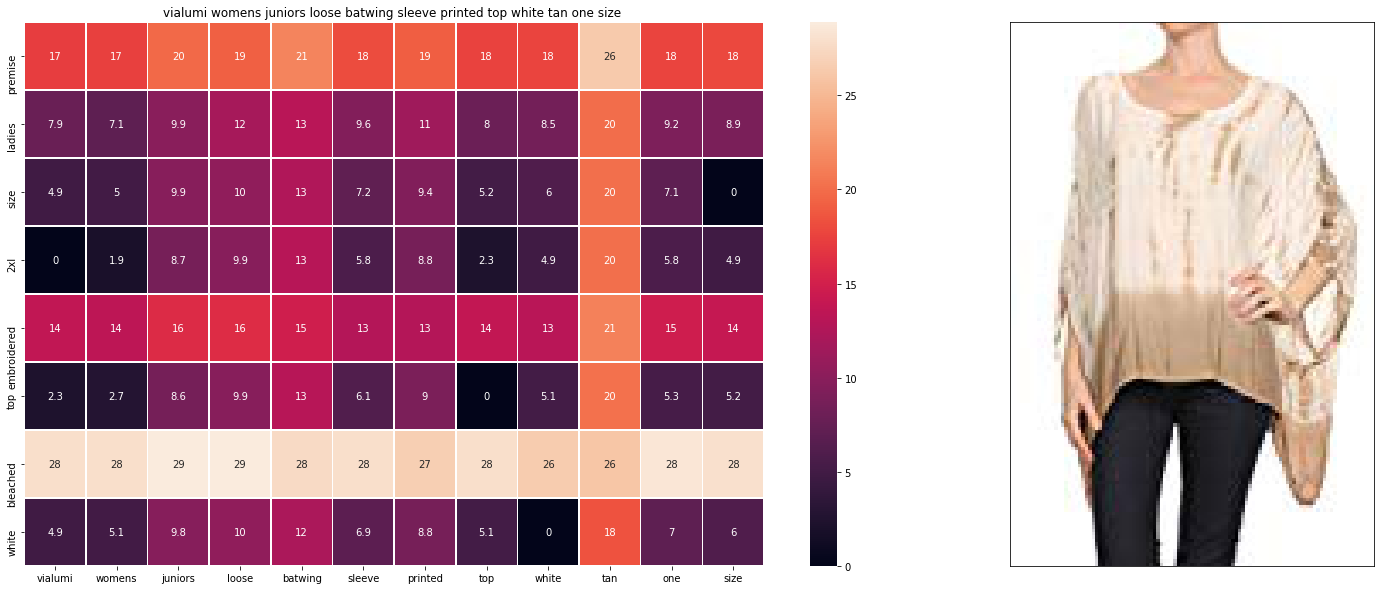

ASIN of the product : B01BN4F3VW
Brand of the product : Vialumi
Title of the product : vialumi womens juniors loose batwing sleeve printed top white tan one size 
Type of the product : SHIRT
Euclidean distance from input : 4.196934204101563


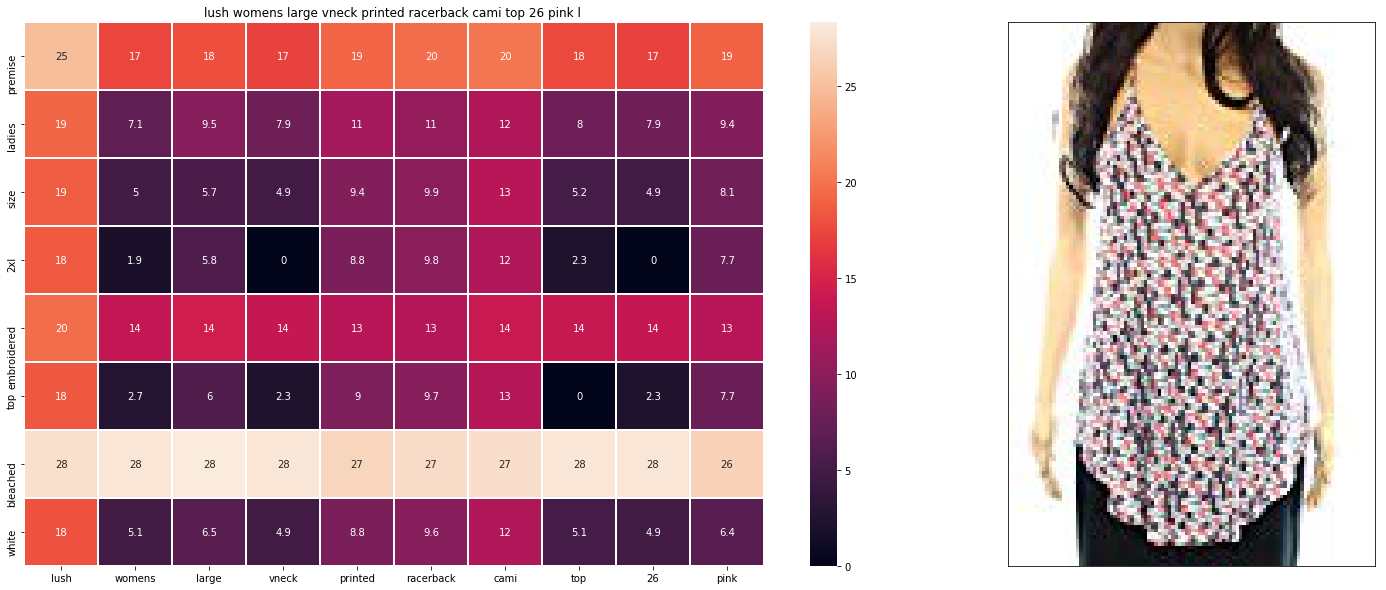

ASIN of the product : B01LY8FVFA
Brand of the product : Lush Clothing
Title of the product : lush womens large vneck printed racerback cami top 26 pink l 
Type of the product : SHIRT
Euclidean distance from input : 4.204068603515625


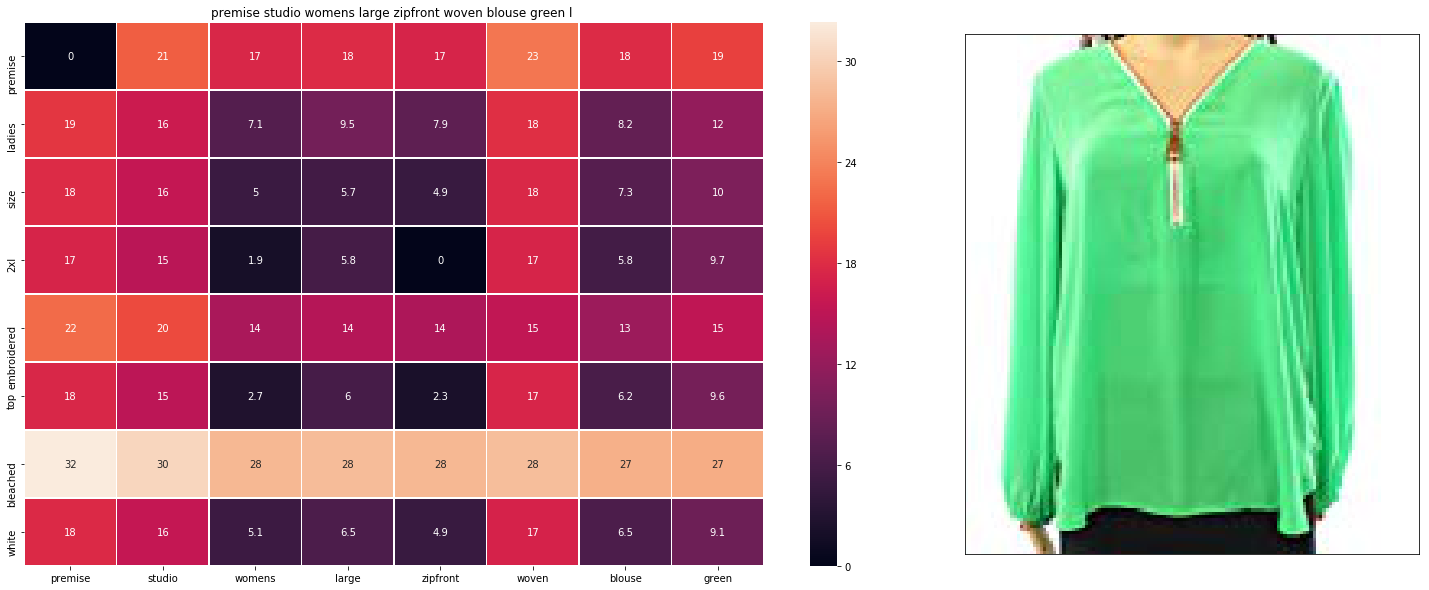

ASIN of the product : B074P8NF7V
Brand of the product : Premise Studio
Title of the product : premise studio womens large zipfront woven blouse green l 
Type of the product : SHIRT
Euclidean distance from input : 4.215960083007812


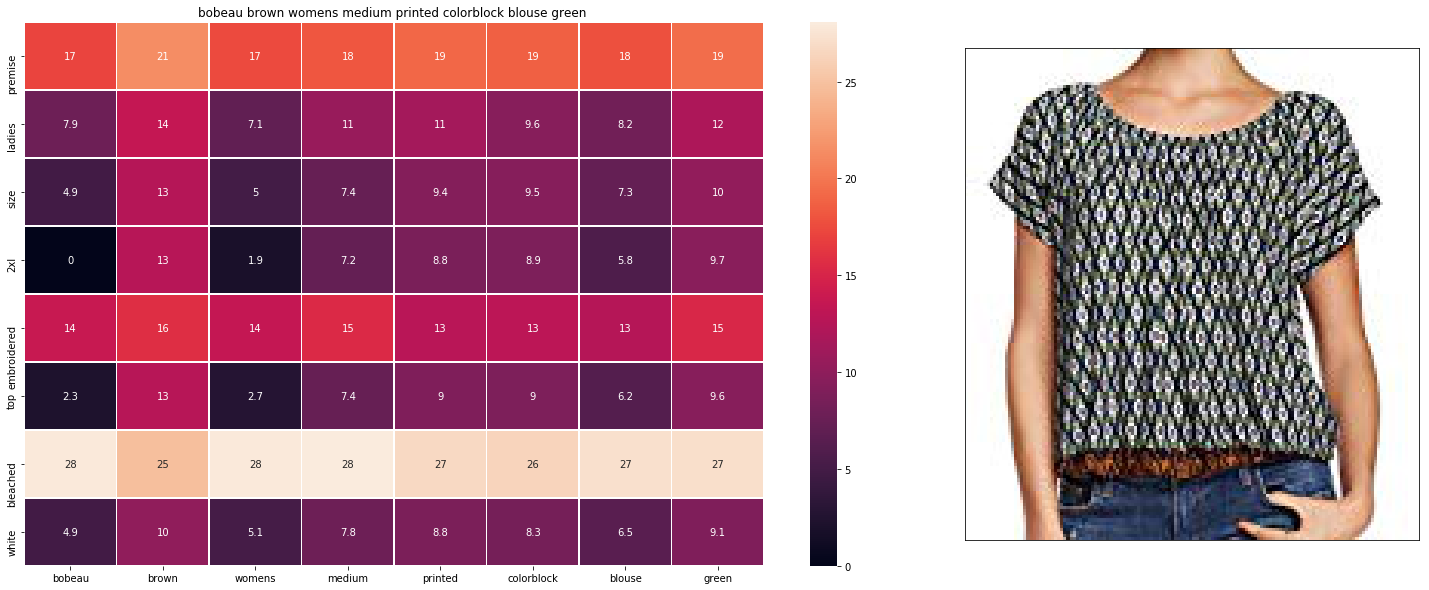

ASIN of the product : B01LXWSQP0
Brand of the product : Bobeau
Title of the product : bobeau brown womens medium printed colorblock blouse green 
Type of the product : SHIRT
Euclidean distance from input : 4.246900939941407


In [21]:
get_similar_products_cnn(12566, 100, 0, 0, 0, 0,  10)

__Giving more weight to the Brand__

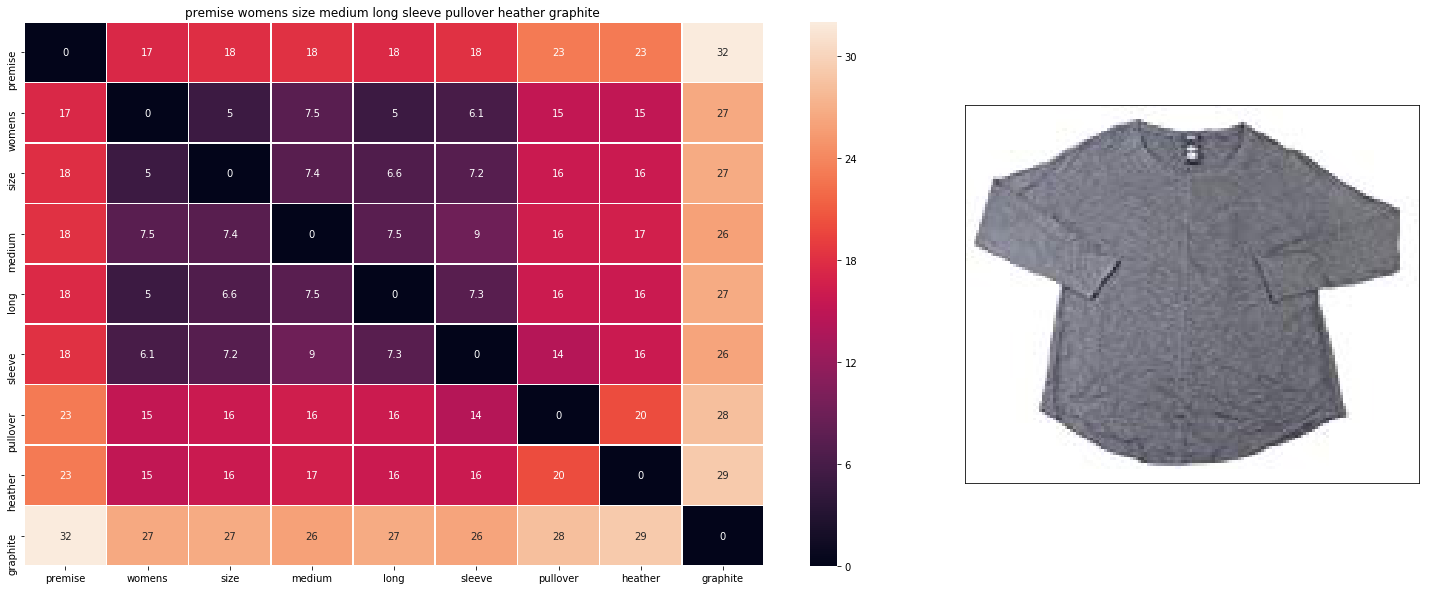

ASIN of the product : B073VTTNQ3
Brand of the product : Premise
Title of the product : premise womens size medium long sleeve pullover heather graphite 
Type of the product : SHIRT
Euclidean distance from input : 0.0


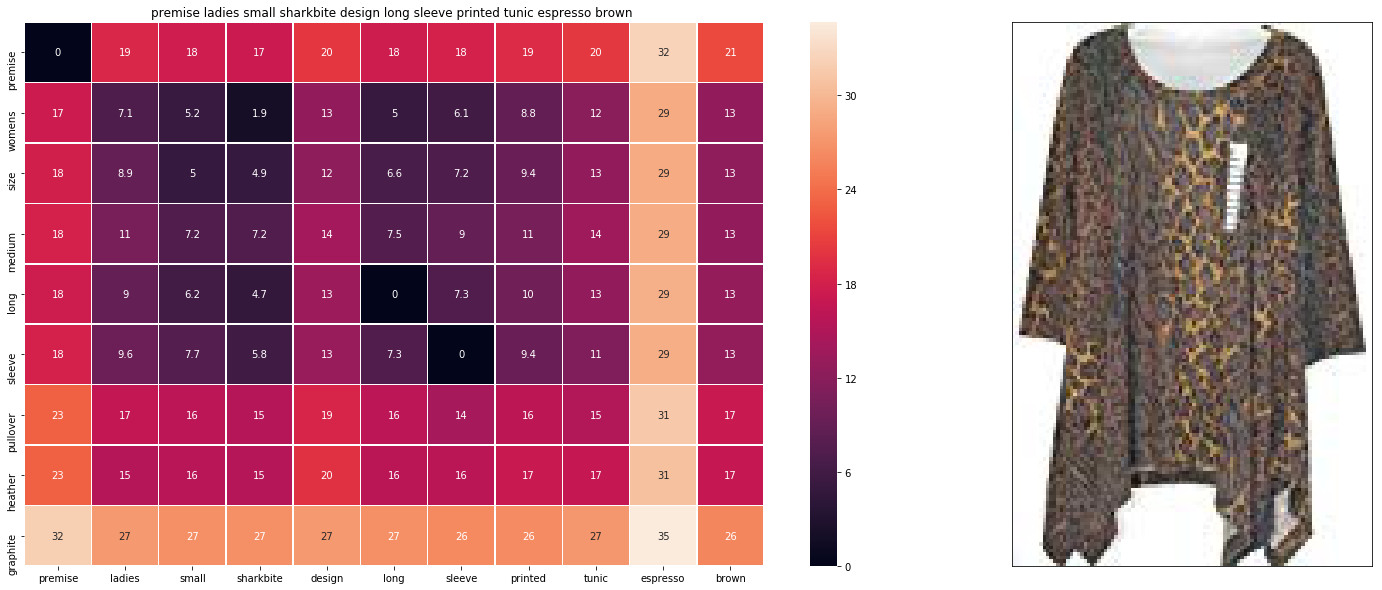

ASIN of the product : B01BCRCYBW
Brand of the product : Premise
Title of the product : premise ladies small sharkbite design long sleeve printed tunic espresso brown 
Type of the product : SHIRT
Euclidean distance from input : 0.0


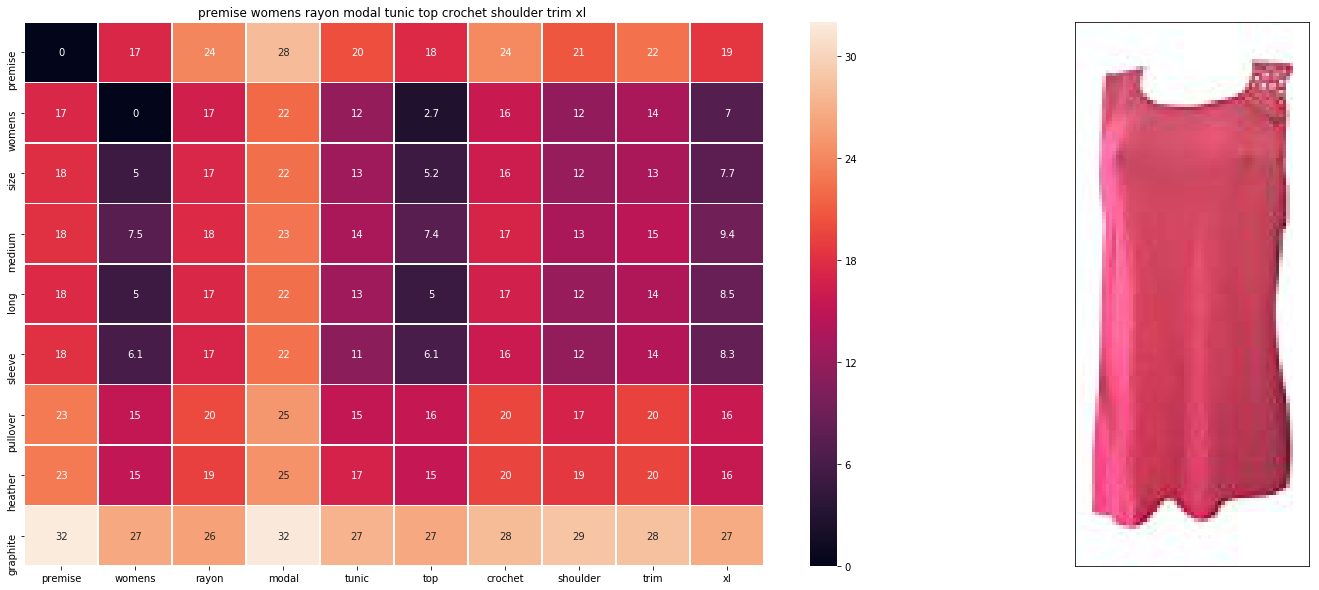

ASIN of the product : B01MG6LRH2
Brand of the product : Premise
Title of the product : premise womens rayon modal tunic top crochet shoulder trim xl 
Type of the product : SHIRT
Euclidean distance from input : 0.0


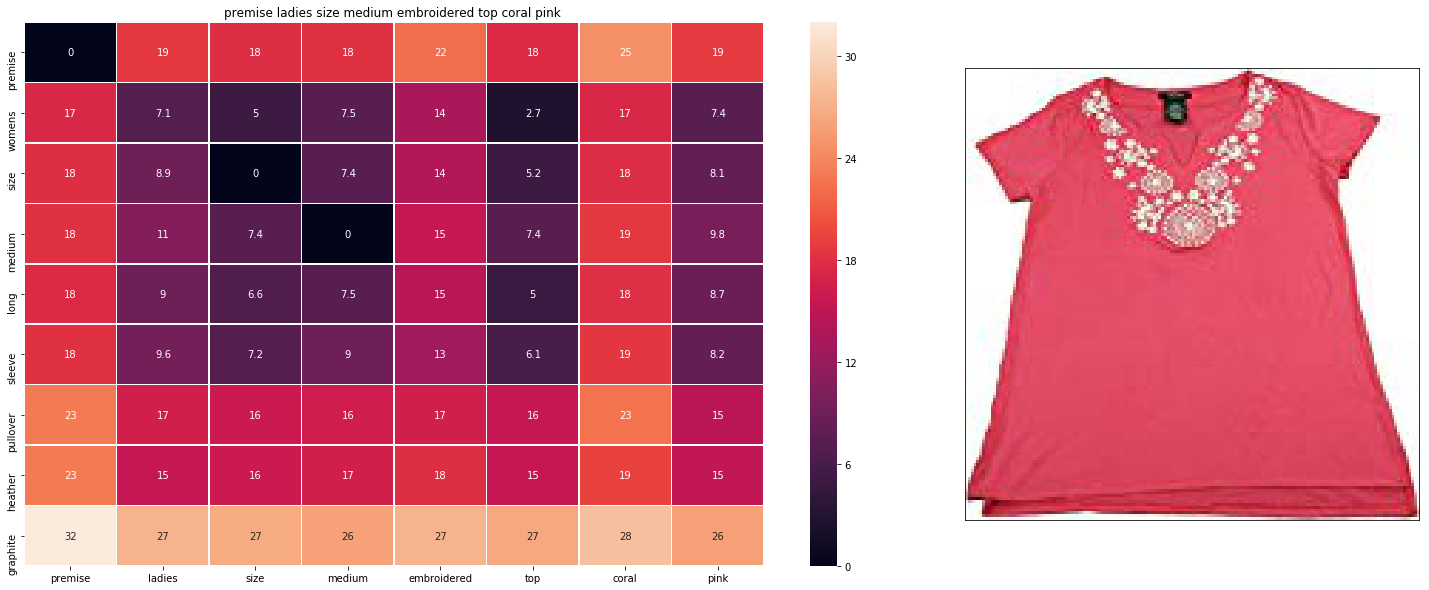

ASIN of the product : B01LWUIZYJ
Brand of the product : Premise
Title of the product : premise ladies size medium embroidered top coral pink 
Type of the product : SHIRT
Euclidean distance from input : 0.0


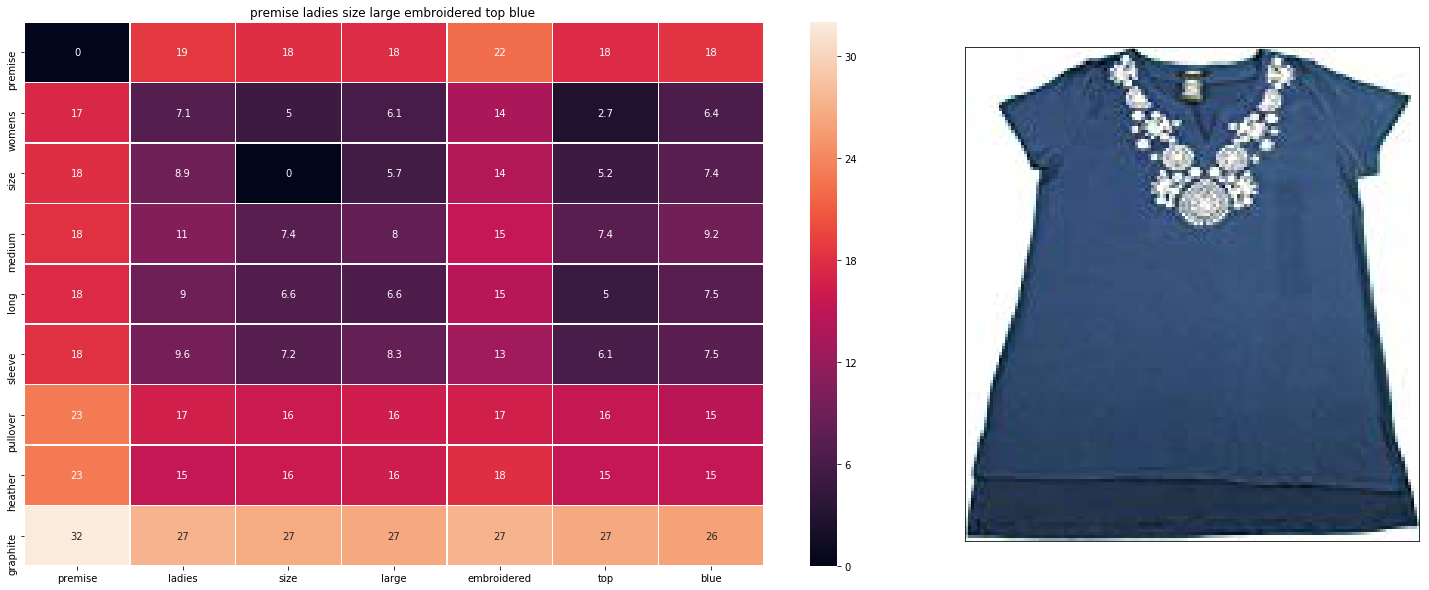

ASIN of the product : B01LFDIDBS
Brand of the product : Premise
Title of the product : premise ladies size large embroidered top blue 
Type of the product : SHIRT
Euclidean distance from input : 0.0


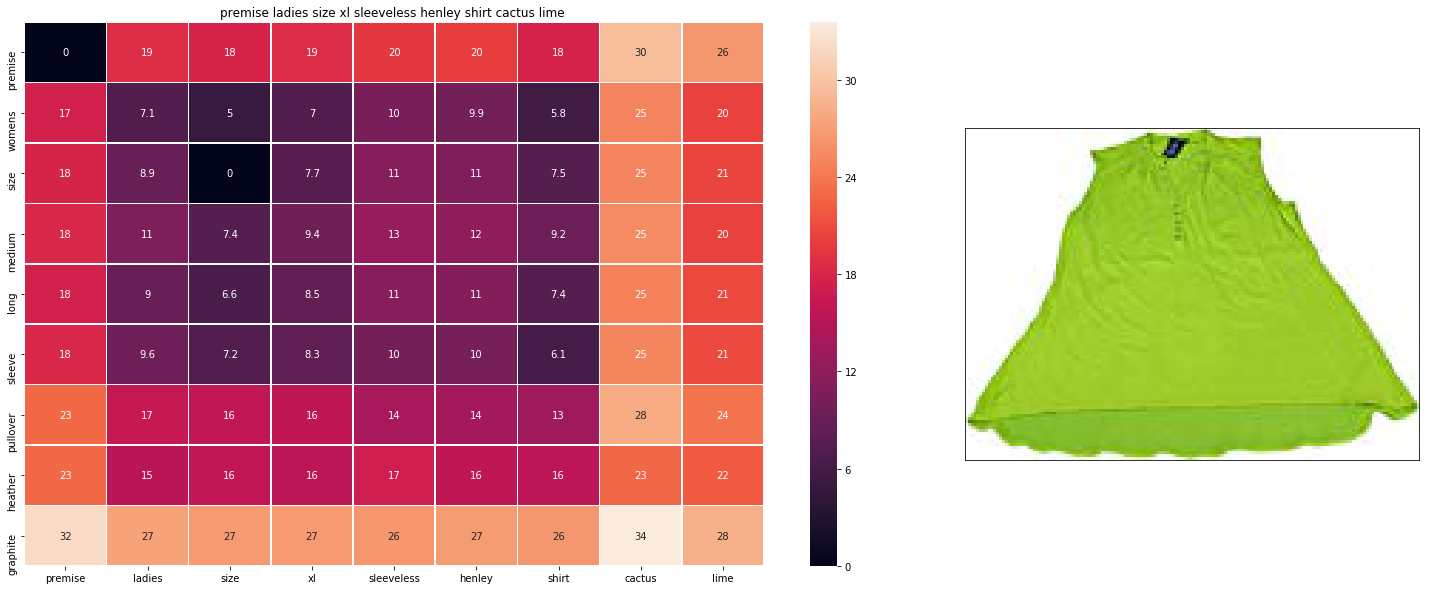

ASIN of the product : B018YE6VF6
Brand of the product : Premise
Title of the product : premise ladies size xl sleeveless henley shirt cactus lime 
Type of the product : SHIRT
Euclidean distance from input : 0.0


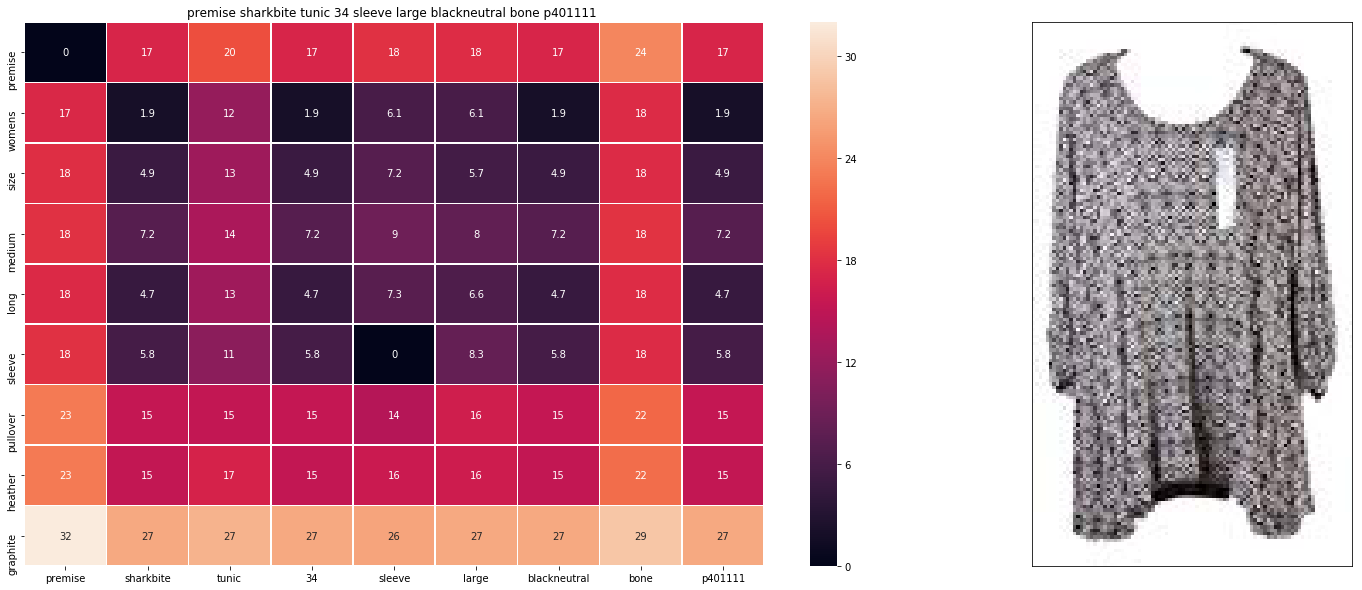

ASIN of the product : B01DUJI0CW
Brand of the product : Premise
Title of the product : premise sharkbite tunic 34 sleeve large blackneutral bone p401111 
Type of the product : SHIRT
Euclidean distance from input : 0.0


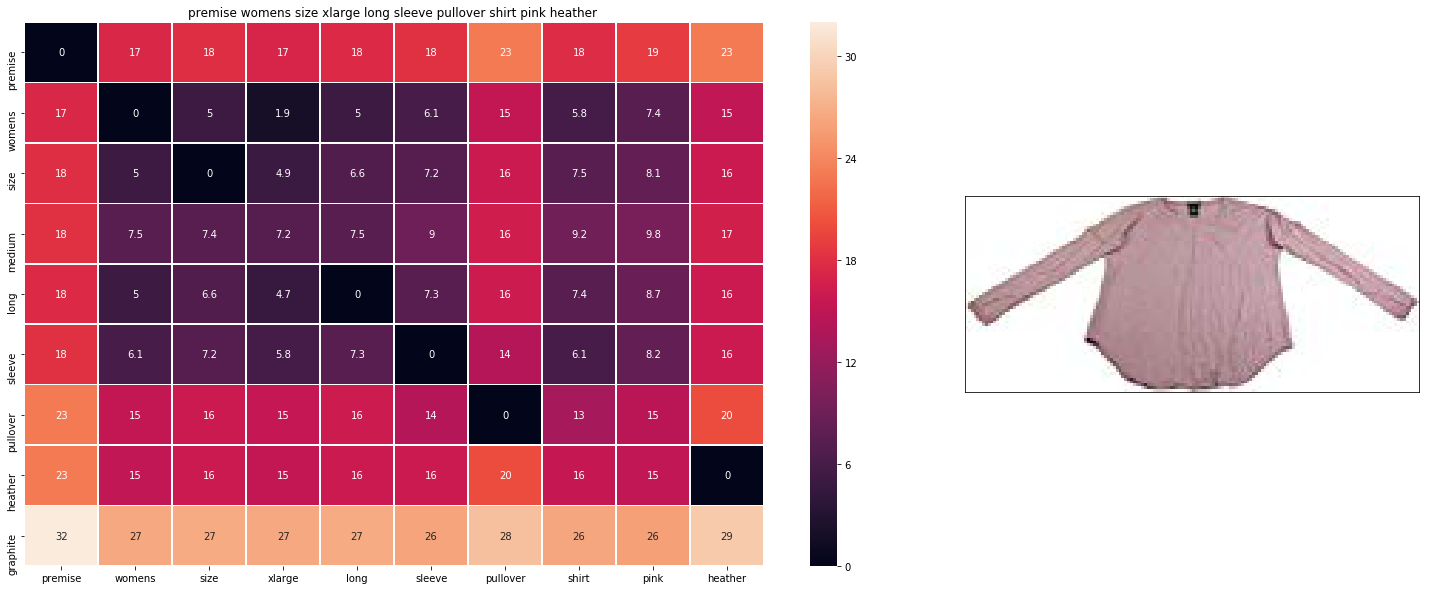

ASIN of the product : B0725LH3SB
Brand of the product : Premise
Title of the product : premise womens size xlarge long sleeve pullover shirt pink heather 
Type of the product : SHIRT
Euclidean distance from input : 0.0


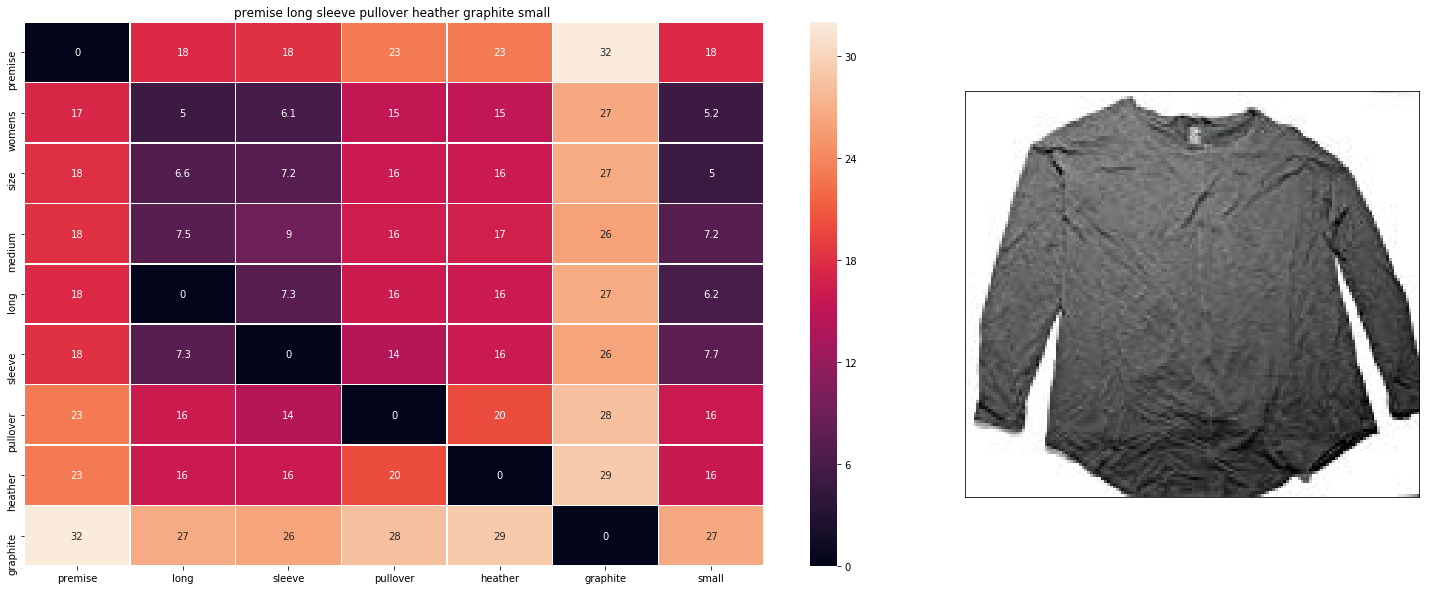

ASIN of the product : B073LW74D3
Brand of the product : Premise
Title of the product : premise long sleeve pullover heather graphite small 
Type of the product : SHIRT
Euclidean distance from input : 0.0


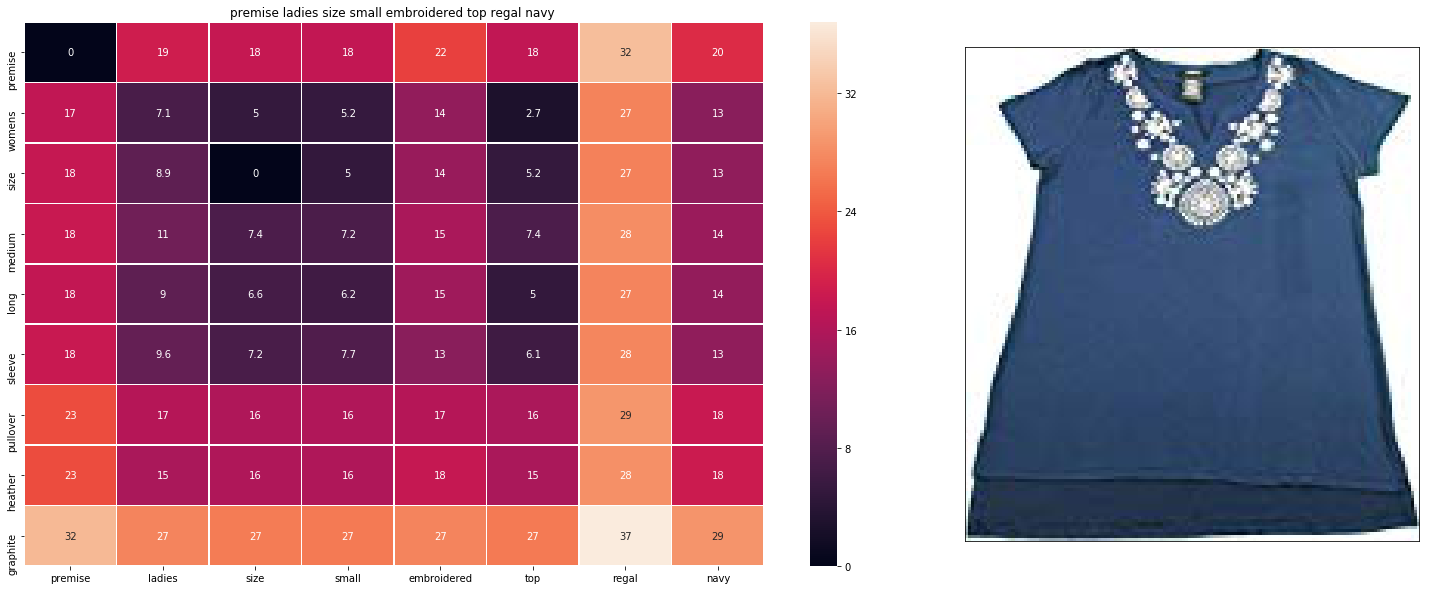

ASIN of the product : B01LWUIEEP
Brand of the product : Premise
Title of the product : premise ladies size small embroidered top regal navy 
Type of the product : SHIRT
Euclidean distance from input : 0.0


In [22]:
get_similar_products_cnn(12566, 0, 100, 0, 0, 0,  10)

__Giving more weight to the Images__

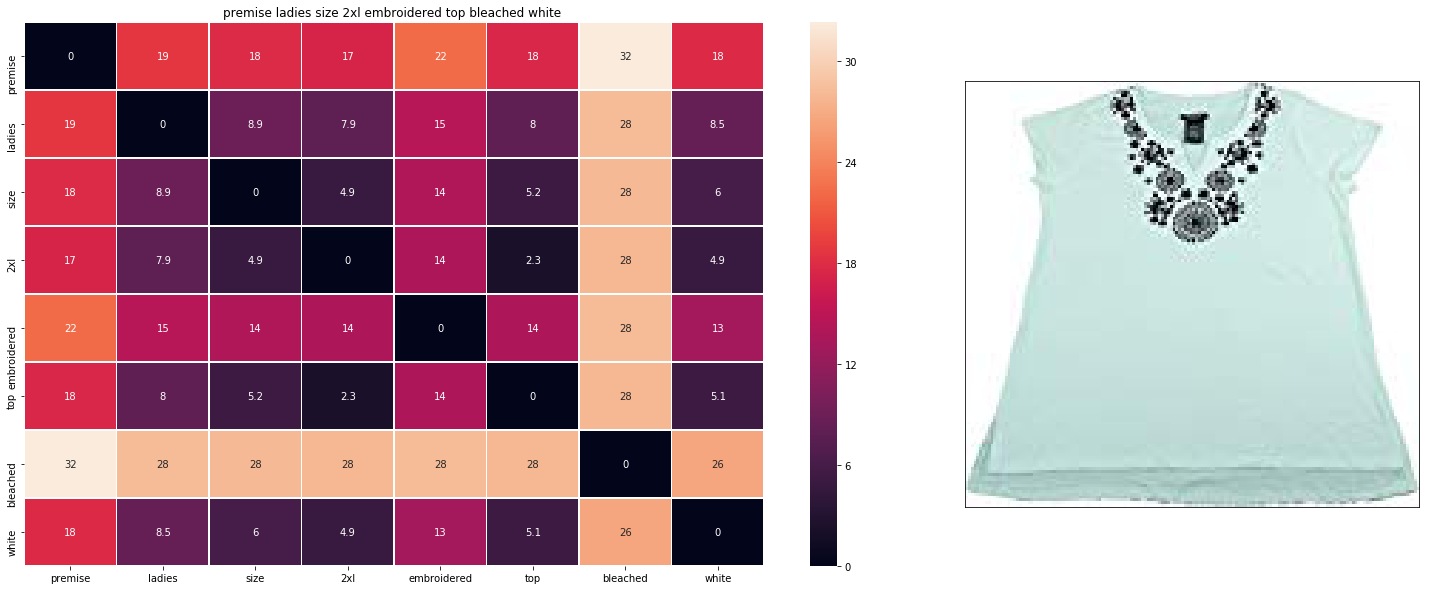

ASIN of the product : B01M0IDUCV
Brand of the product : Premise
Title of the product : premise ladies size 2xl embroidered top bleached white 
Type of the product : SHIRT
Euclidean distance from input : 0.04419417381286621


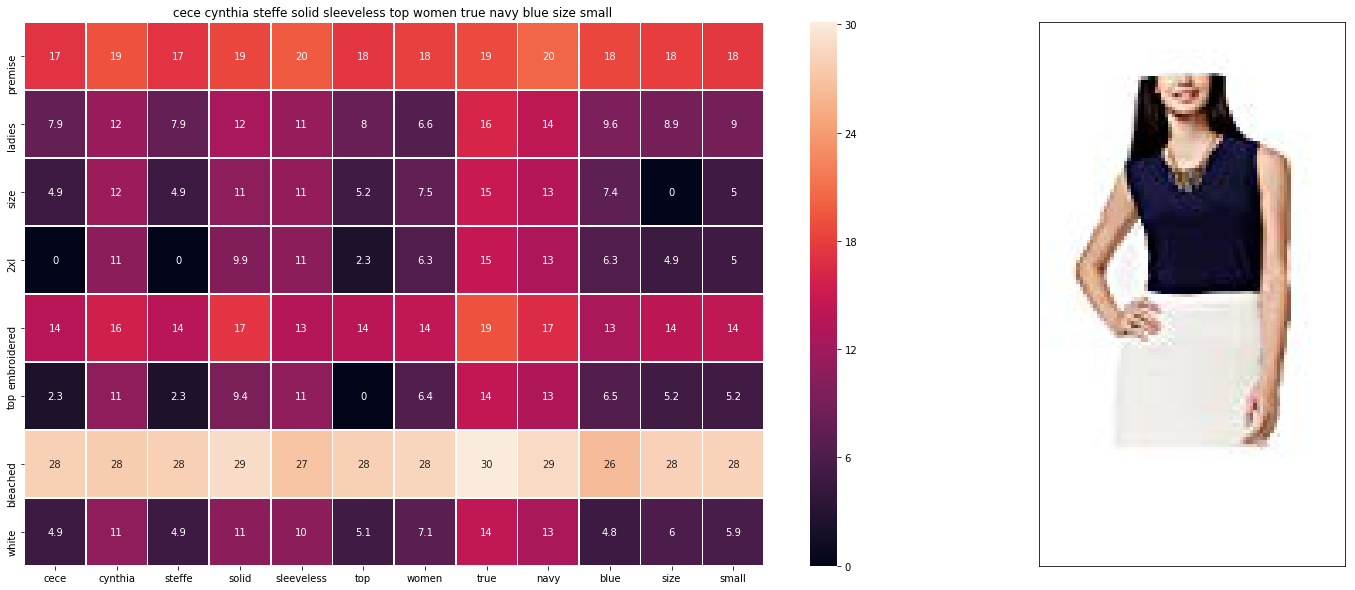

ASIN of the product : B01N4NQ7LX
Brand of the product : CeCe by Cynthia Steffe
Title of the product : cece cynthia steffe solid sleeveless top women true navy blue size small 
Type of the product : SHIRT
Euclidean distance from input : 30.05005615234375


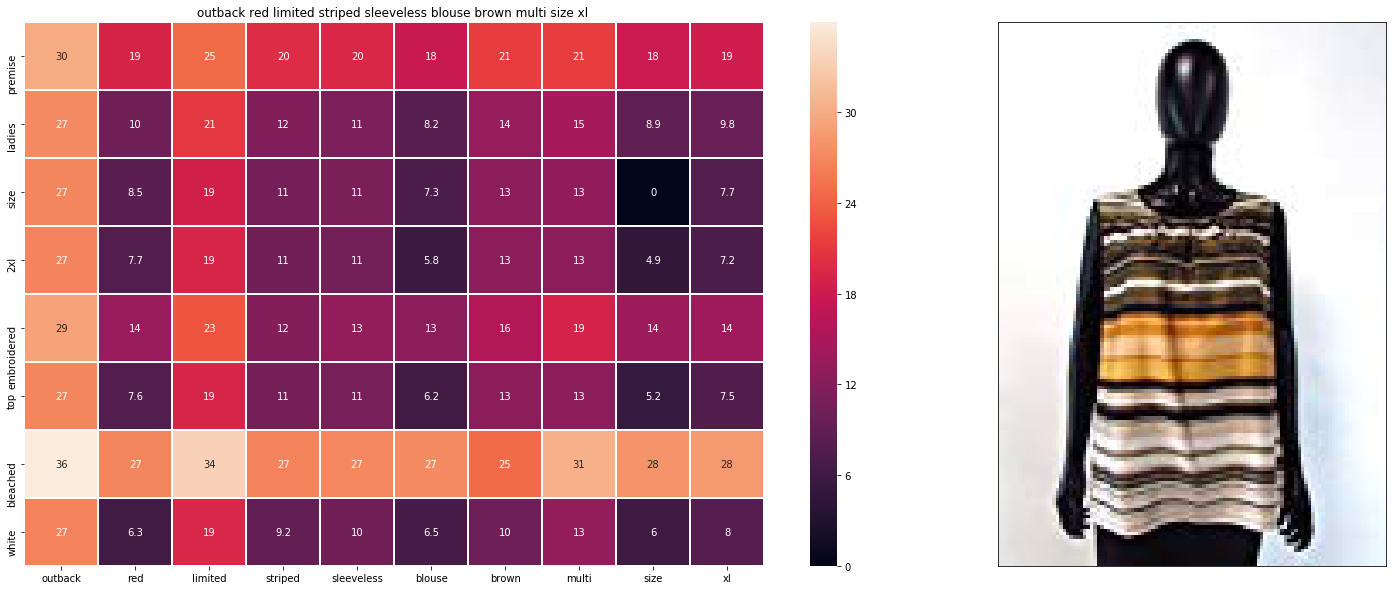

ASIN of the product : B01IU645VU
Brand of the product : Outback Red
Title of the product : outback red limited striped sleeveless blouse brown multi size xl 
Type of the product : SHIRT
Euclidean distance from input : 41.26111328125


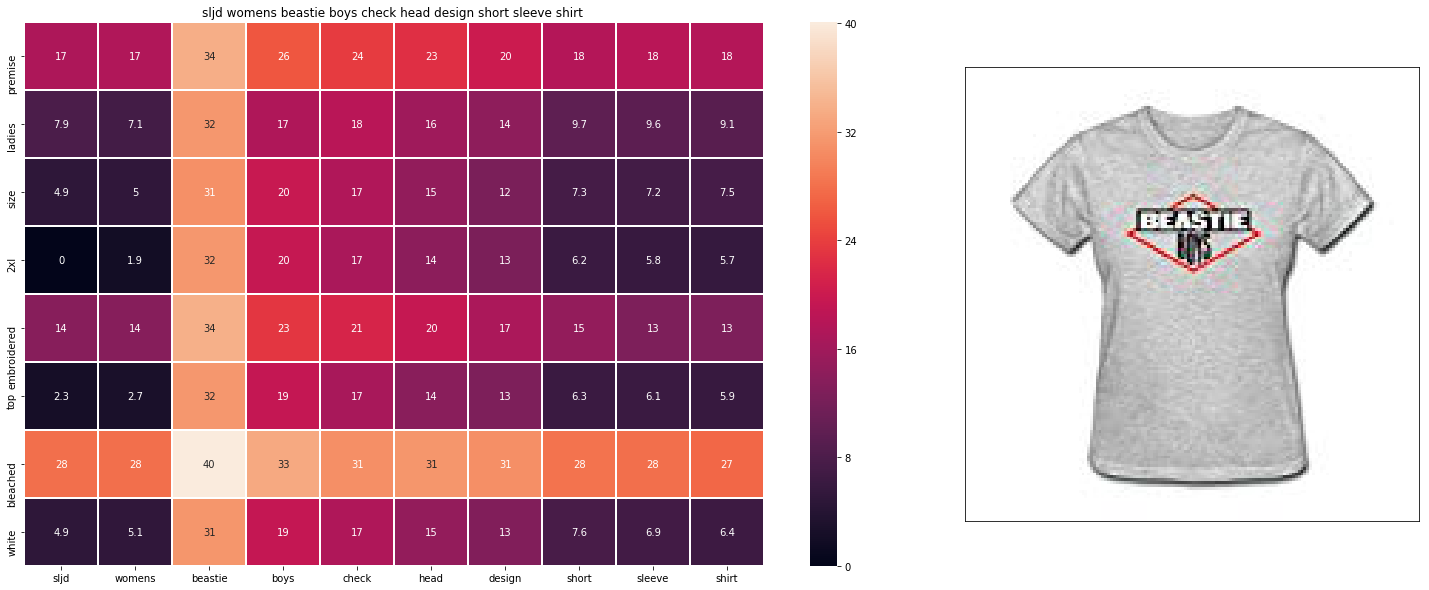

ASIN of the product : B01FQLKKMK
Brand of the product : SLJD
Title of the product : sljd womens beastie boys check head design short sleeve shirt 
Type of the product : BOOKS_1973_AND_LATER
Euclidean distance from input : 44.0002001953125


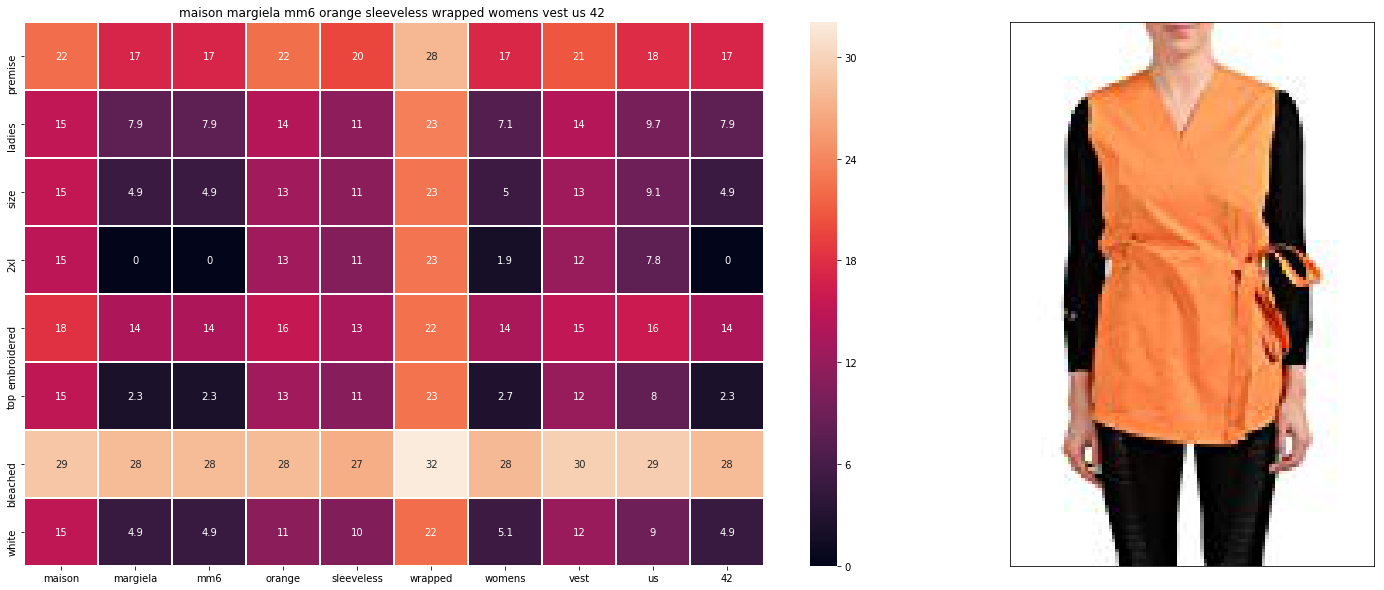

ASIN of the product : B01MXI5L4G
Brand of the product : Maison Margiela MM6
Title of the product : maison margiela mm6 orange sleeveless wrapped womens vest us 42 
Type of the product : SHIRT
Euclidean distance from input : 47.382509765625


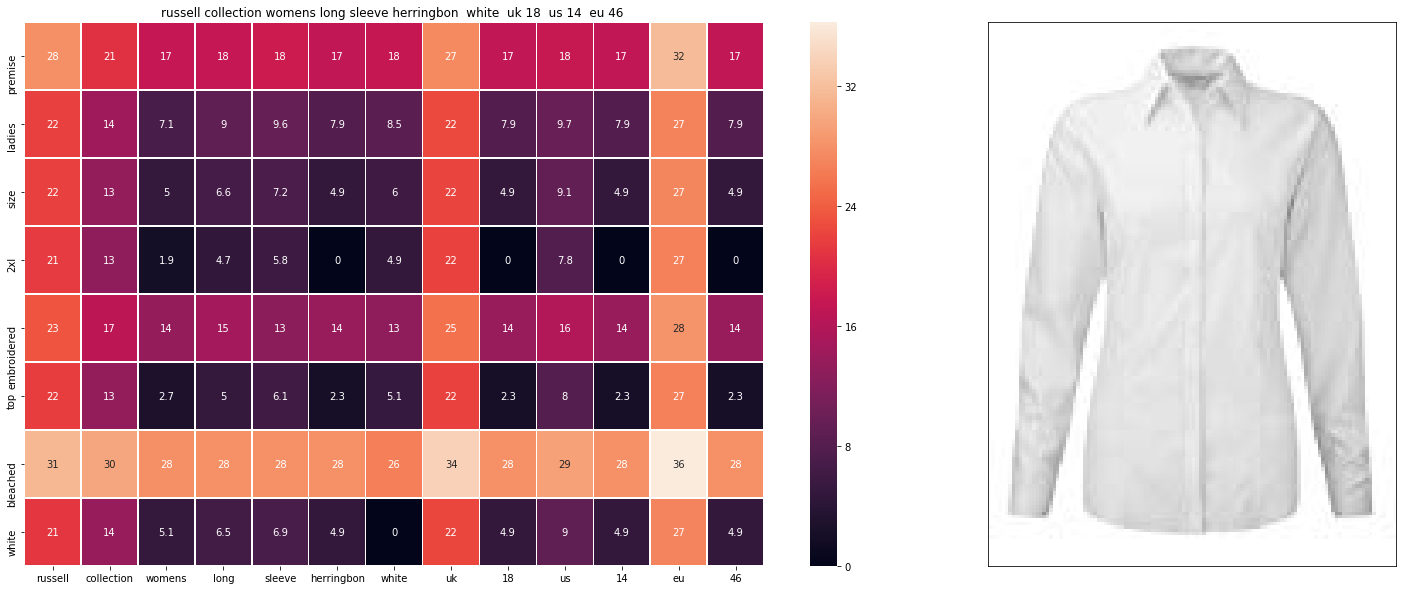

ASIN of the product : B00K77AN5S
Brand of the product : Russell Collection
Title of the product : russell collection womens long sleeve herringbon  white  uk 18  us 14  eu 46 
Type of the product : SHIRT
Euclidean distance from input : 47.7183935546875


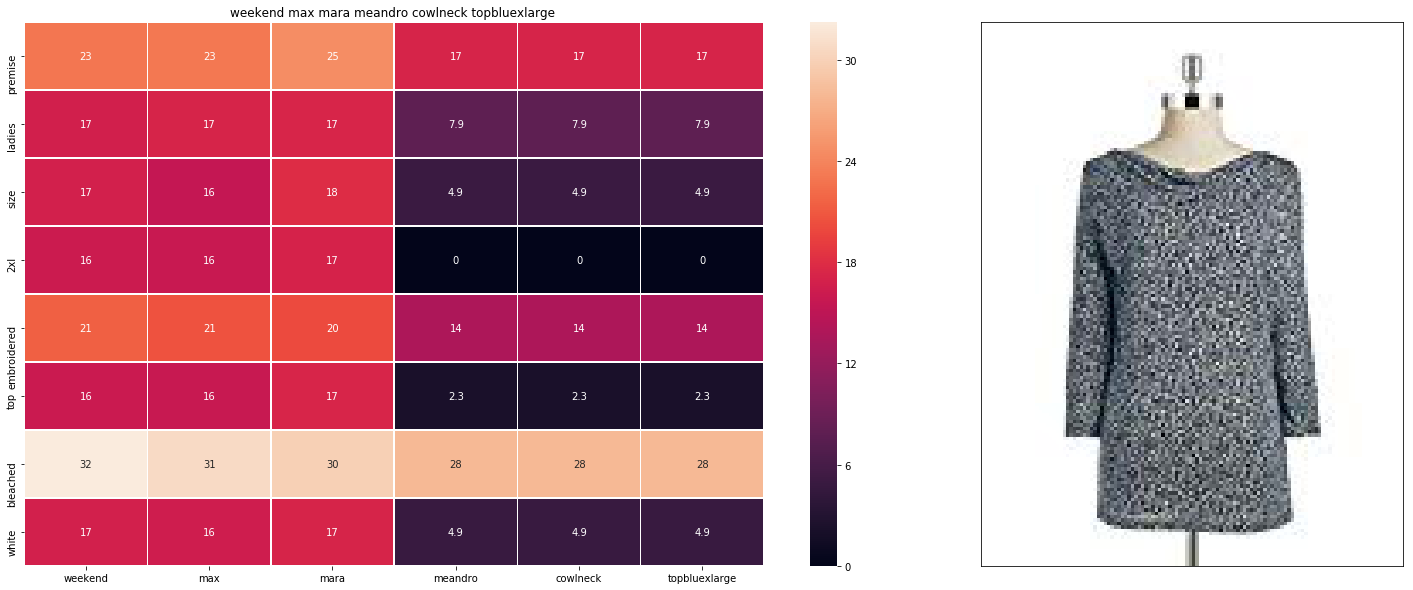

ASIN of the product : B01MG83UB4
Brand of the product : MaxMara
Title of the product : weekend max mara meandro cowlneck topbluexlarge 
Type of the product : SHIRT
Euclidean distance from input : 47.902099609375


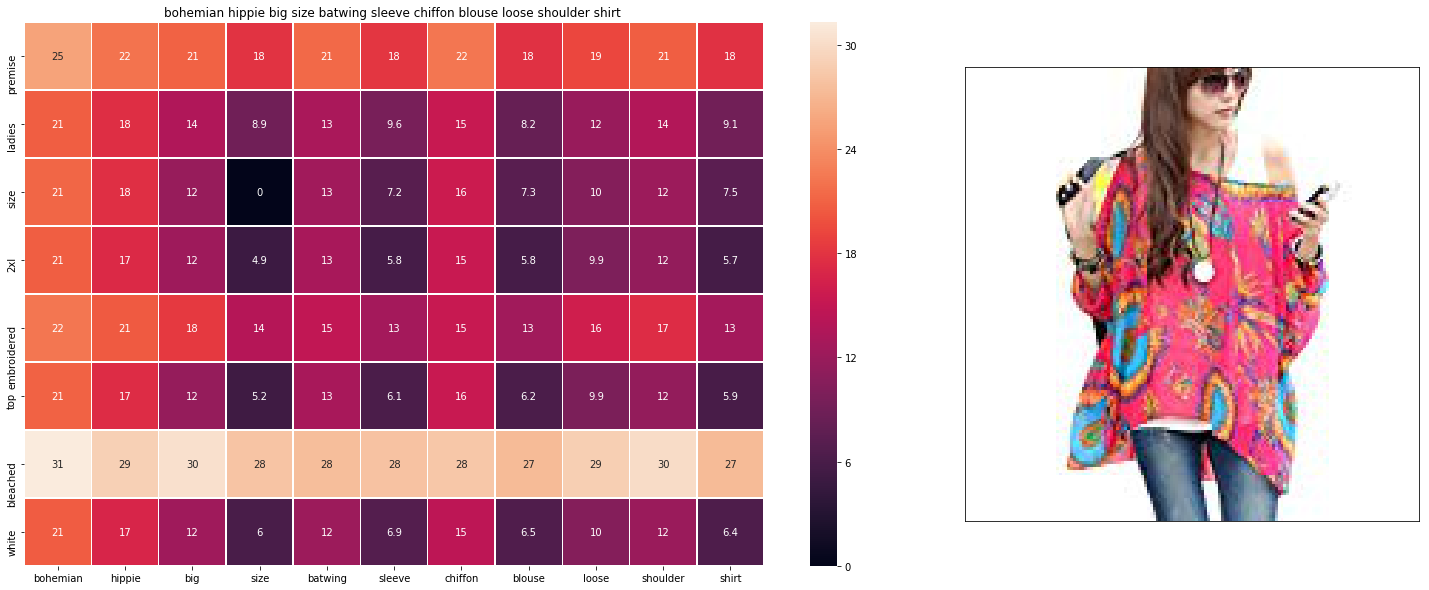

ASIN of the product : B00YC92VRU
Brand of the product : Display Promotion
Title of the product : bohemian hippie big size batwing sleeve chiffon blouse loose shoulder shirt 
Type of the product : SHIRT
Euclidean distance from input : 48.04646484375


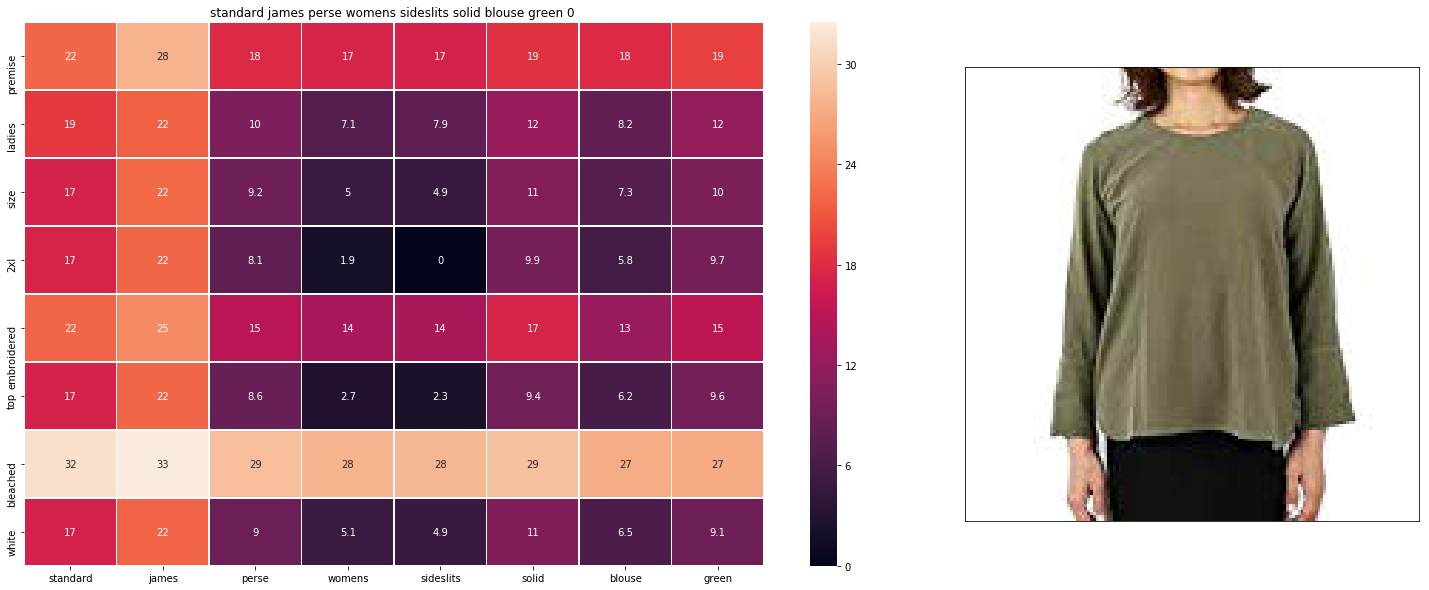

ASIN of the product : B071LMW4YG
Brand of the product : Standard James Perse
Title of the product : standard james perse womens sideslits solid blouse green 0 
Type of the product : SHIRT
Euclidean distance from input : 48.101875


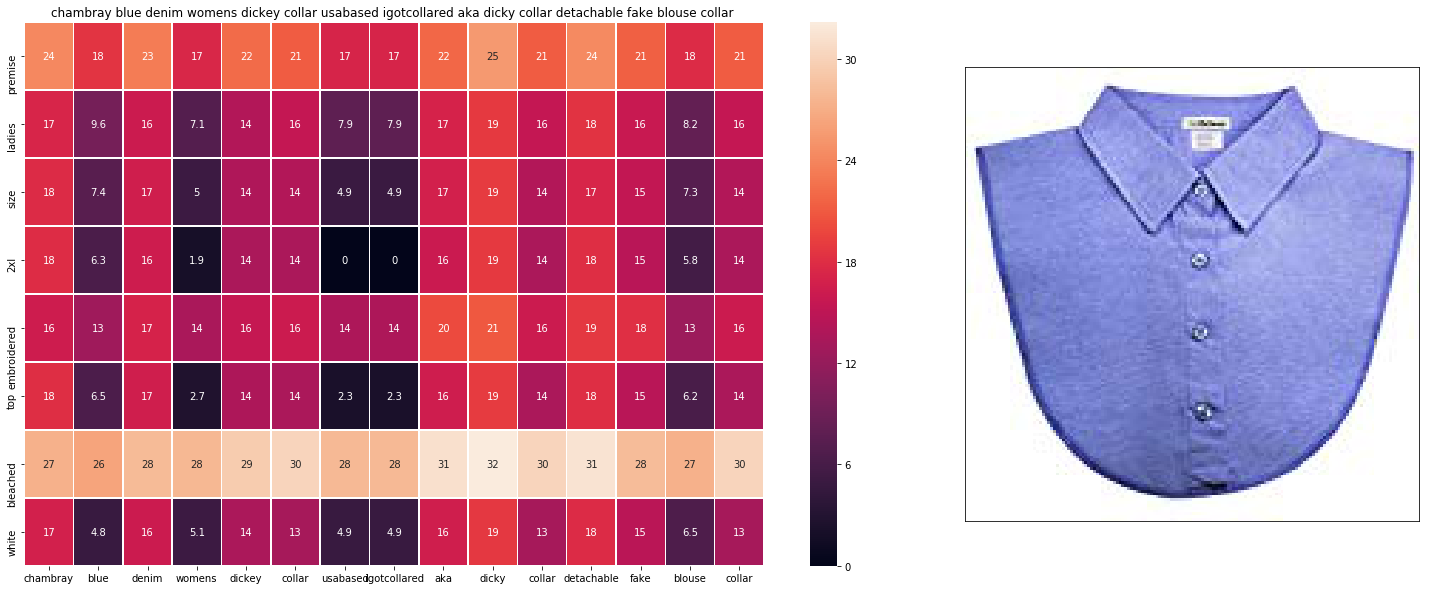

ASIN of the product : B01MQWKWME
Brand of the product : IGotCollared
Title of the product : chambray blue denim womens dickey collar usabased igotcollared aka dicky collar detachable fake blouse collar 
Type of the product : SHIRT
Euclidean distance from input : 48.118896484375


In [23]:
get_similar_products_cnn(12566, 0, 0, 100, 0, 0,  10)

__Giving more weight to the colour__

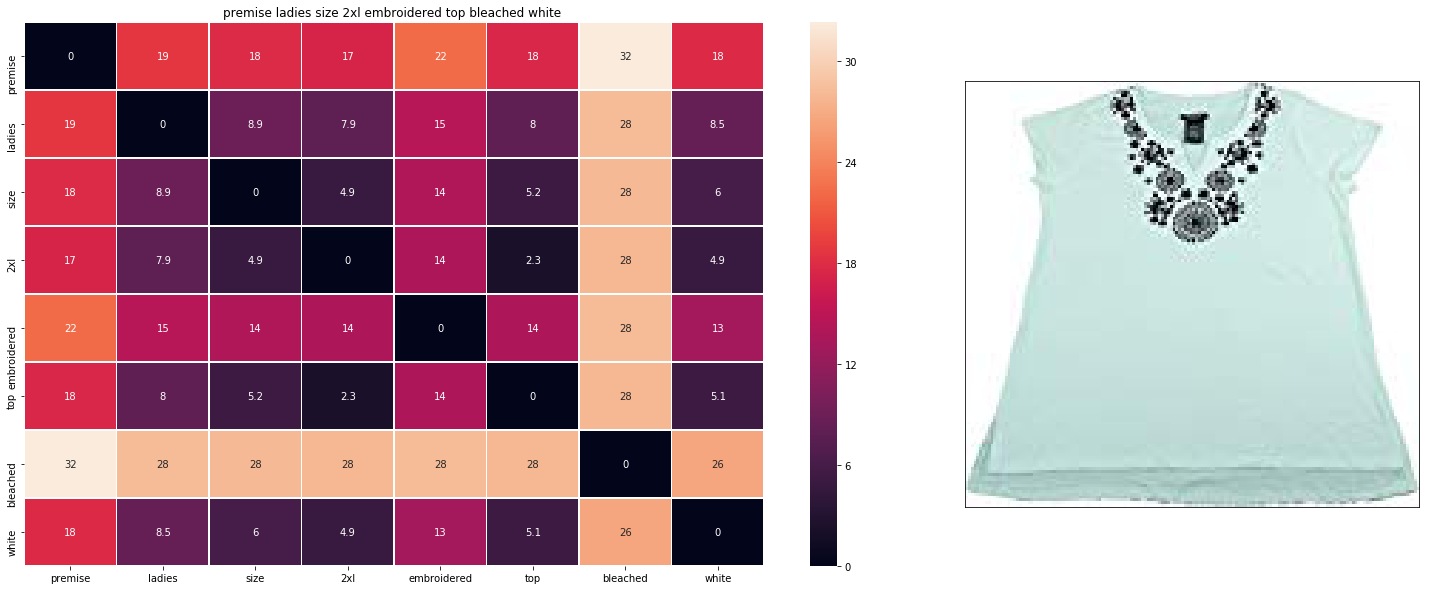

ASIN of the product : B01M0IDUCV
Brand of the product : Premise
Title of the product : premise ladies size 2xl embroidered top bleached white 
Type of the product : SHIRT
Euclidean distance from input : 0.0


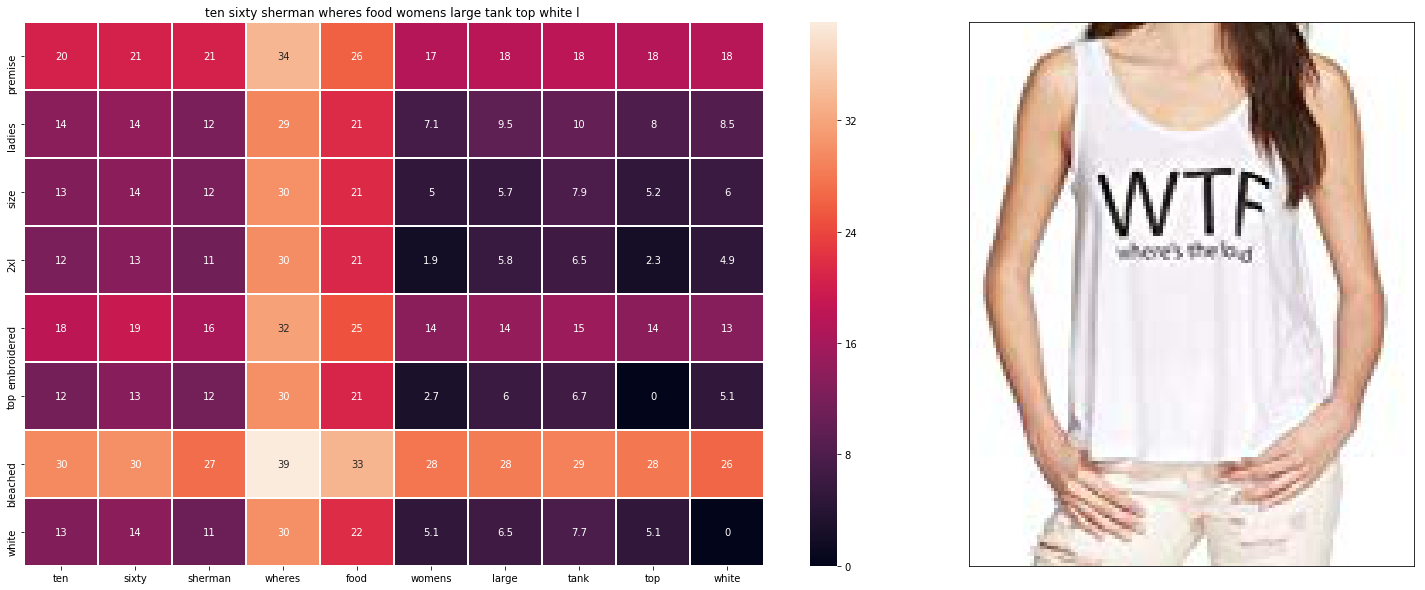

ASIN of the product : B071ZJ6ZQX
Brand of the product : Ten Sixty Sherman
Title of the product : ten sixty sherman wheres food womens large tank top white l 
Type of the product : SHIRT
Euclidean distance from input : 1.0


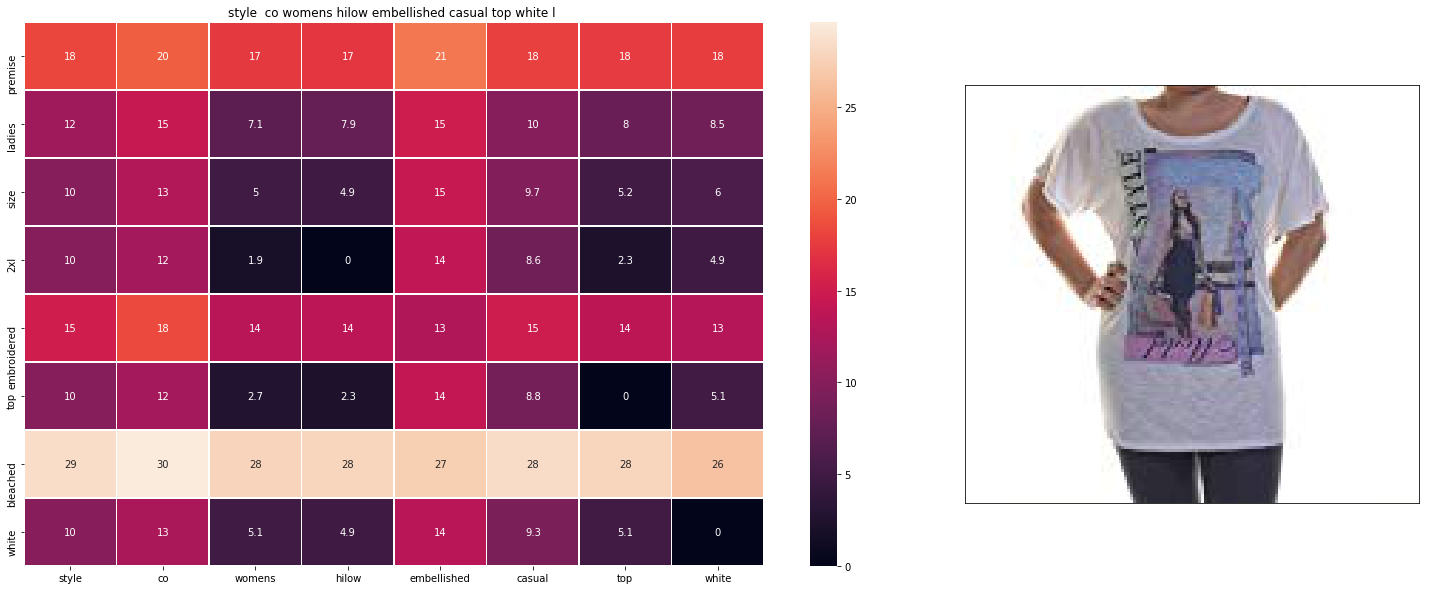

ASIN of the product : B01AK5U0R2
Brand of the product : Style & Co.
Title of the product : style  co womens hilow embellished casual top white l 
Type of the product : SHIRT
Euclidean distance from input : 1.0


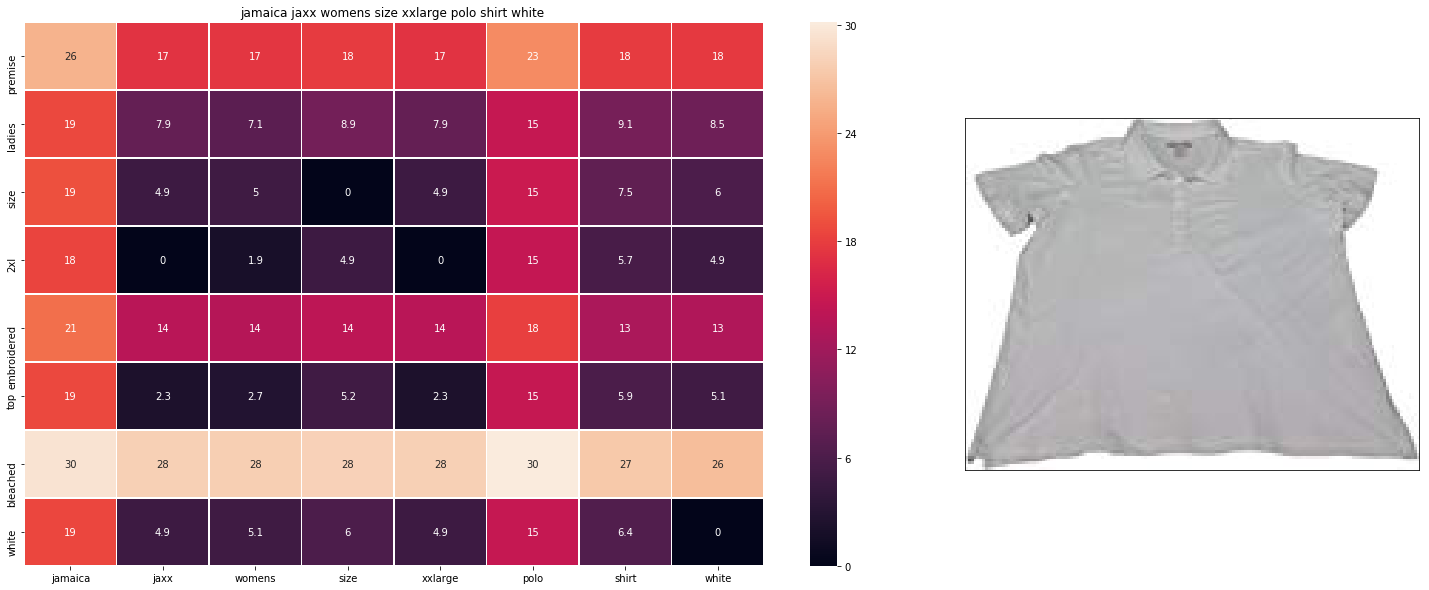

ASIN of the product : B014E8I2WG
Brand of the product : Jamaica Jaxx
Title of the product : jamaica jaxx womens size xxlarge polo shirt white 
Type of the product : SHIRT
Euclidean distance from input : 1.0


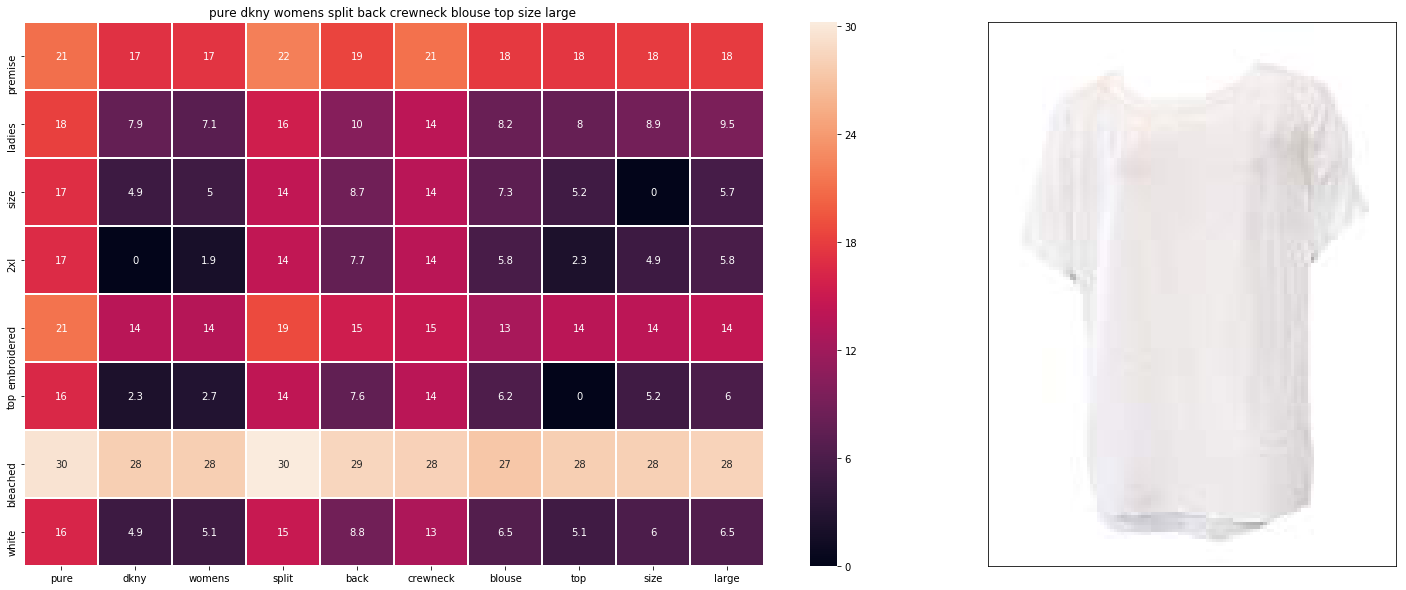

ASIN of the product : B01HISG95Q
Brand of the product : DKNY
Title of the product : pure dkny womens split back crewneck blouse top size large 
Type of the product : SHIRT
Euclidean distance from input : 1.0


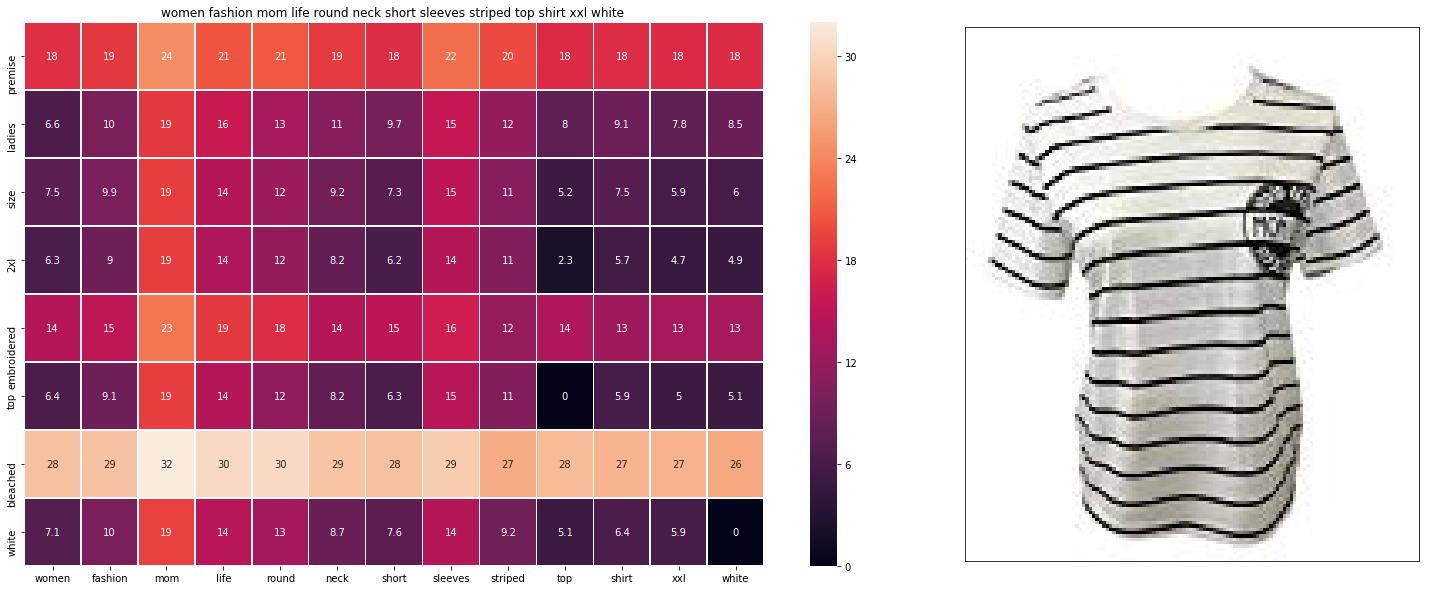

ASIN of the product : B06W2LTMLN
Brand of the product : NORAME
Title of the product : women fashion mom life round neck short sleeves striped top shirt xxl white 
Type of the product : BOOKS_1973_AND_LATER
Euclidean distance from input : 1.0


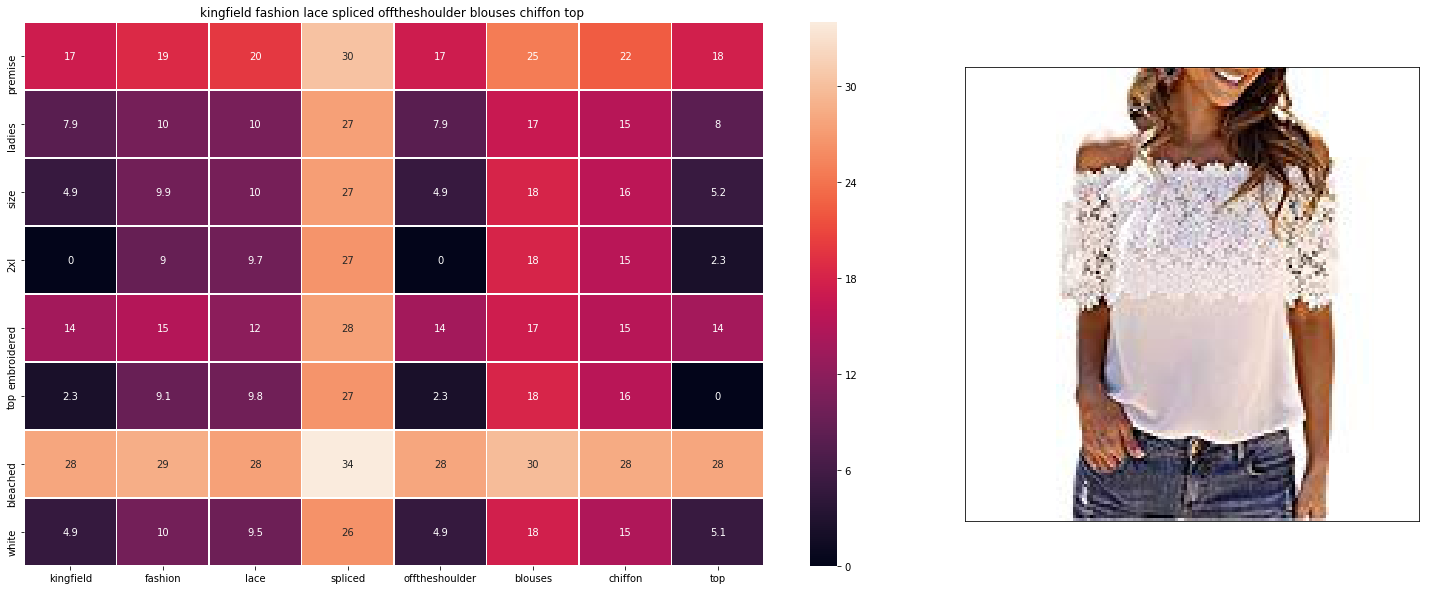

ASIN of the product : B01C0E9DRE
Brand of the product : KingField
Title of the product : kingfield fashion lace spliced offtheshoulder blouses chiffon top 
Type of the product : SHIRT
Euclidean distance from input : 1.0


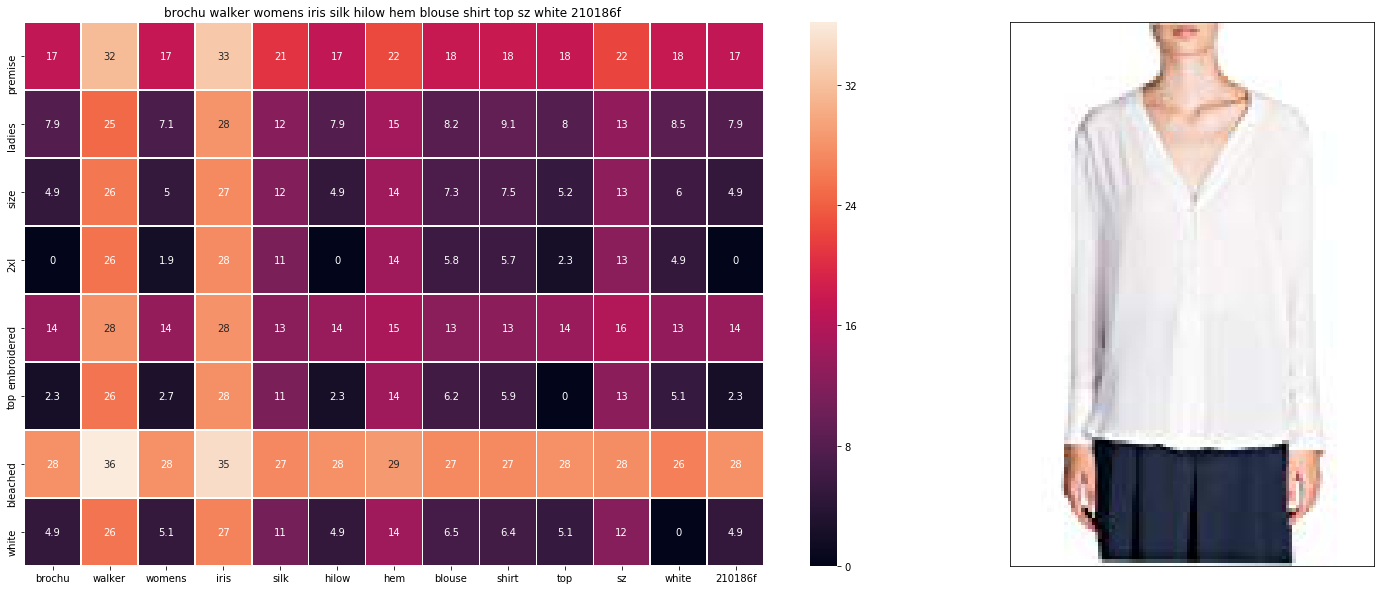

ASIN of the product : B014HJM9X0
Brand of the product : Brochu Walker
Title of the product : brochu walker womens iris silk hilow hem blouse shirt top sz white 210186f 
Type of the product : SHIRT
Euclidean distance from input : 1.0


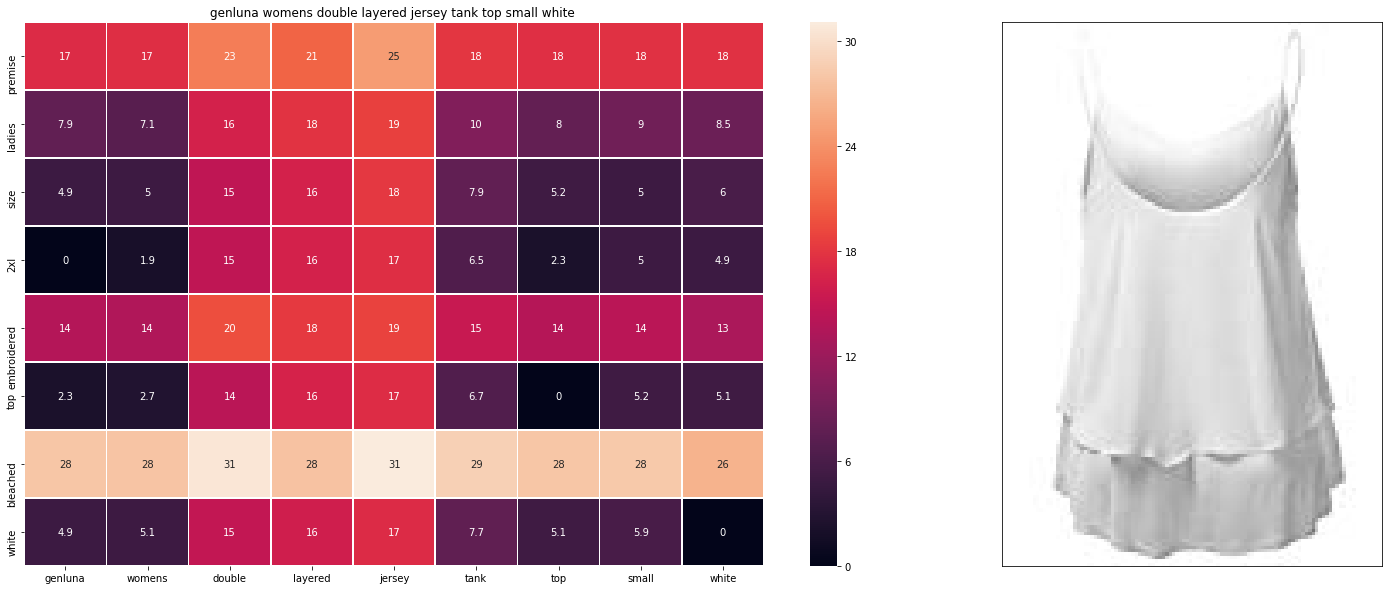

ASIN of the product : B01NB9H60M
Brand of the product : Genluna
Title of the product : genluna womens double layered jersey tank top small white 
Type of the product : SHIRT
Euclidean distance from input : 1.0


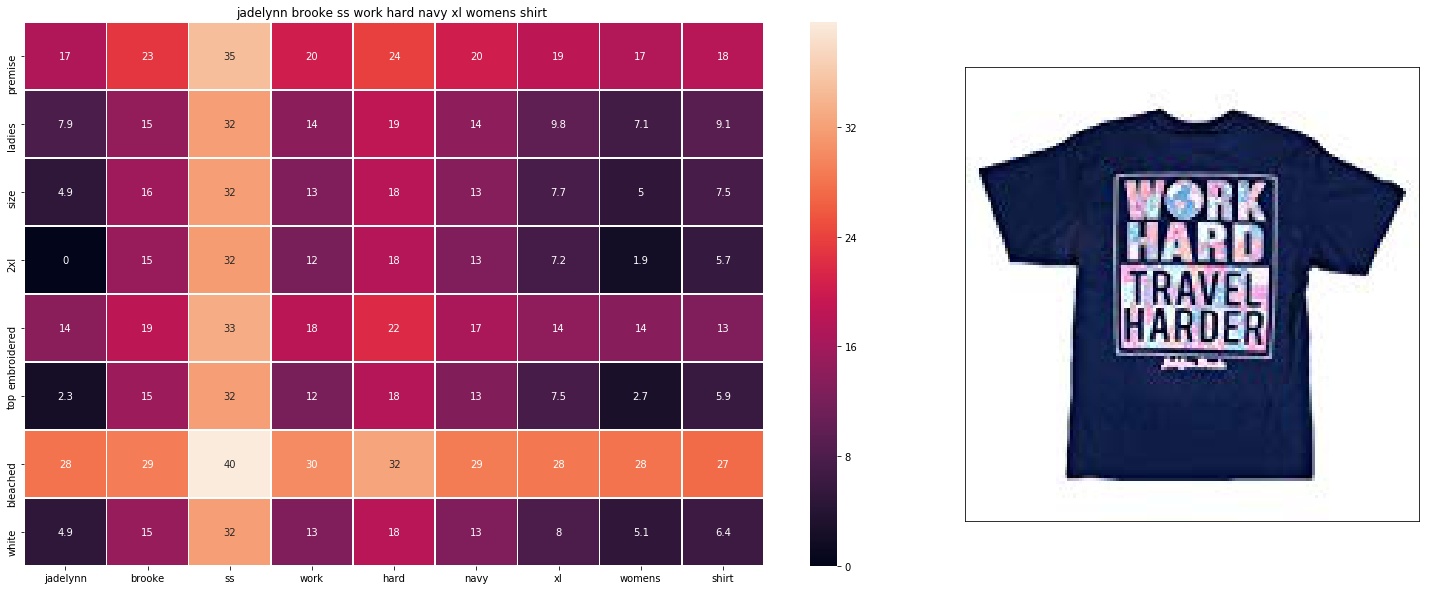

ASIN of the product : B00OB84954
Brand of the product : Liuqiuhu
Title of the product : jadelynn brooke ss work hard navy xl womens shirt 
Type of the product : SHIRT
Euclidean distance from input : 1.0


In [24]:
get_similar_products_cnn(12566, 0, 0, 0, 100, 0,  10)

__Giving more weight to the Types__

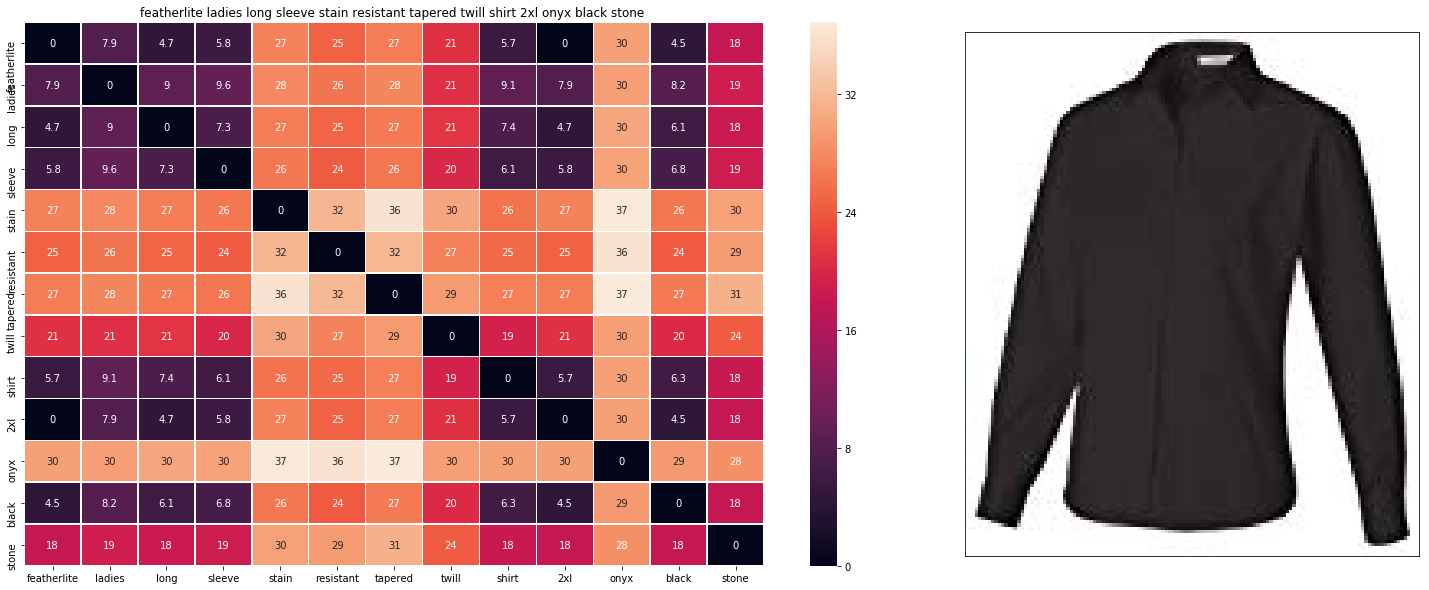

ASIN of the product : B004GSI2OS
Brand of the product : FeatherLite
Title of the product : featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone 
Type of the product : SHIRT
Euclidean distance from input : 0.0


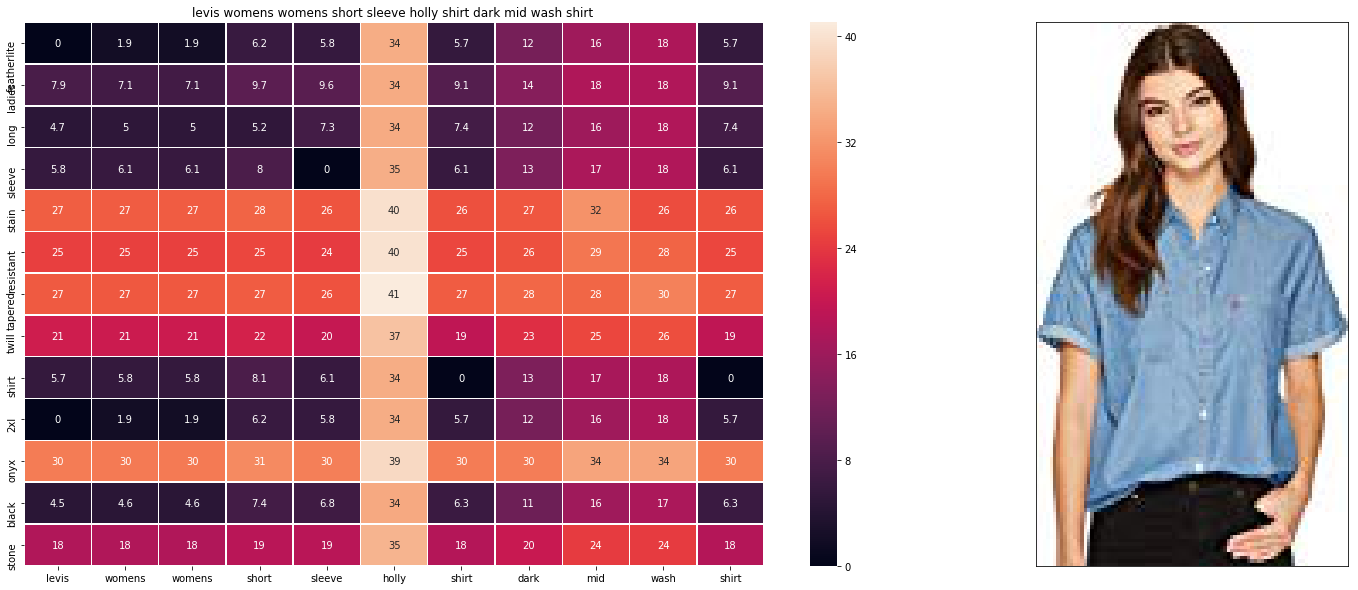

ASIN of the product : B07253SY36
Brand of the product : Levi's® Womens
Title of the product : levis womens womens short sleeve holly shirt dark mid wash shirt 
Type of the product : SHIRT
Euclidean distance from input : 0.0


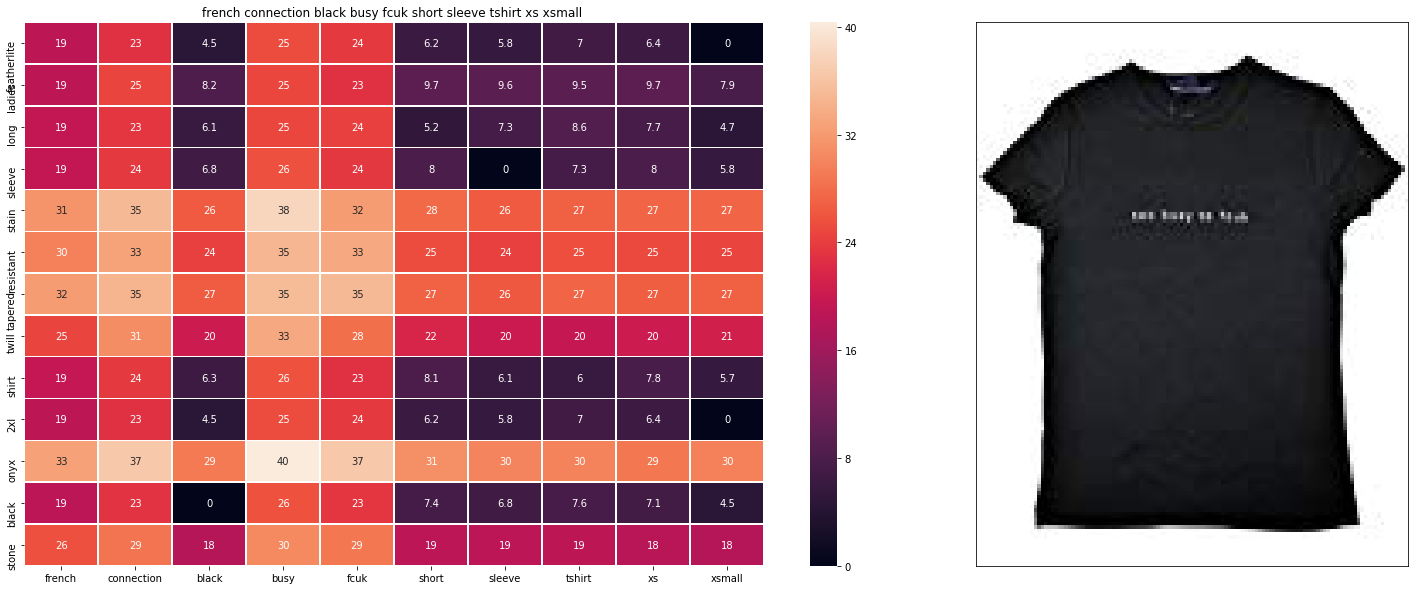

ASIN of the product : B01BUI92SG
Brand of the product : French Connection
Title of the product : french connection black busy fcuk short sleeve tshirt xs xsmall 
Type of the product : SHIRT
Euclidean distance from input : 0.0


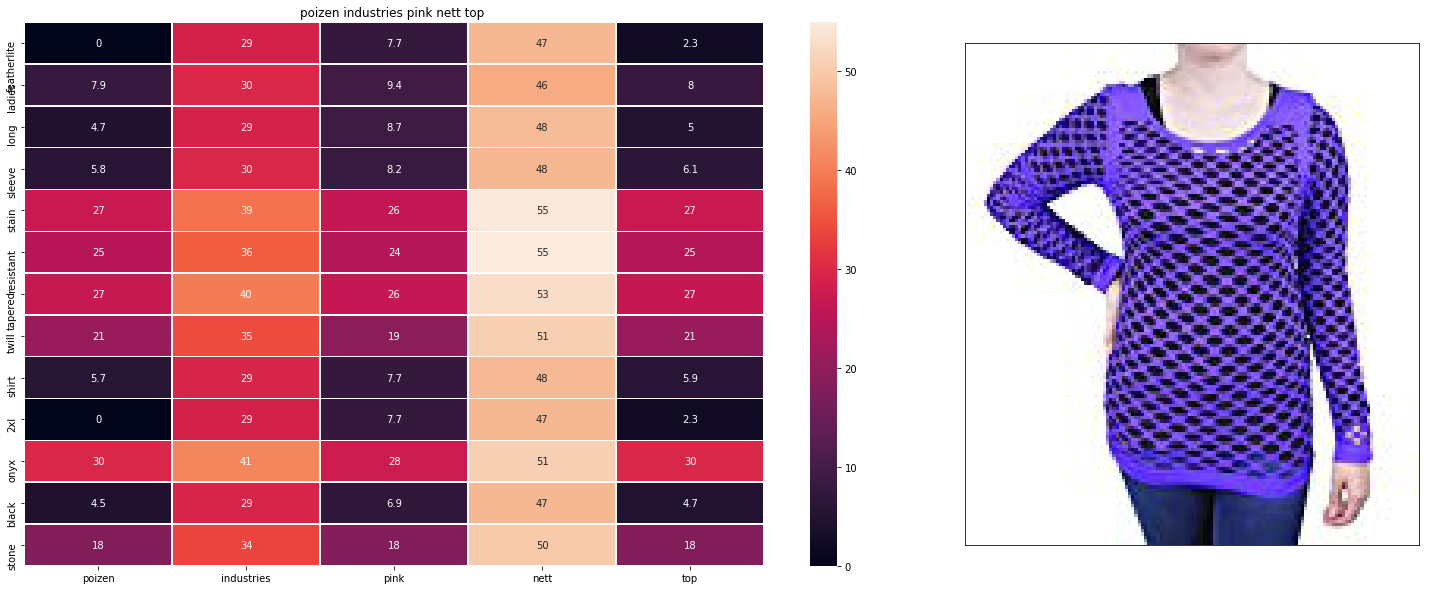

ASIN of the product : B01D4L0RS6
Brand of the product : Poizen Industries
Title of the product : poizen industries pink nett top 
Type of the product : SHIRT
Euclidean distance from input : 0.0


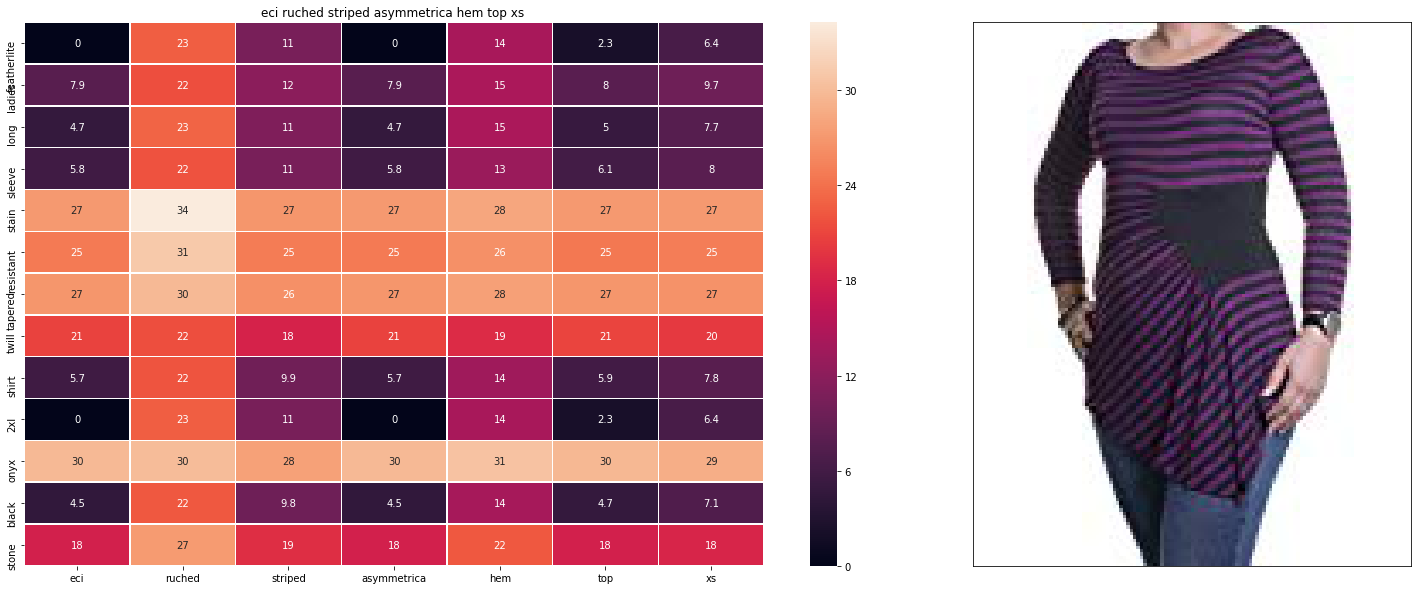

ASIN of the product : B015HKOPS0
Brand of the product : ECI
Title of the product : eci ruched striped asymmetrica hem top xs 
Type of the product : SHIRT
Euclidean distance from input : 0.0


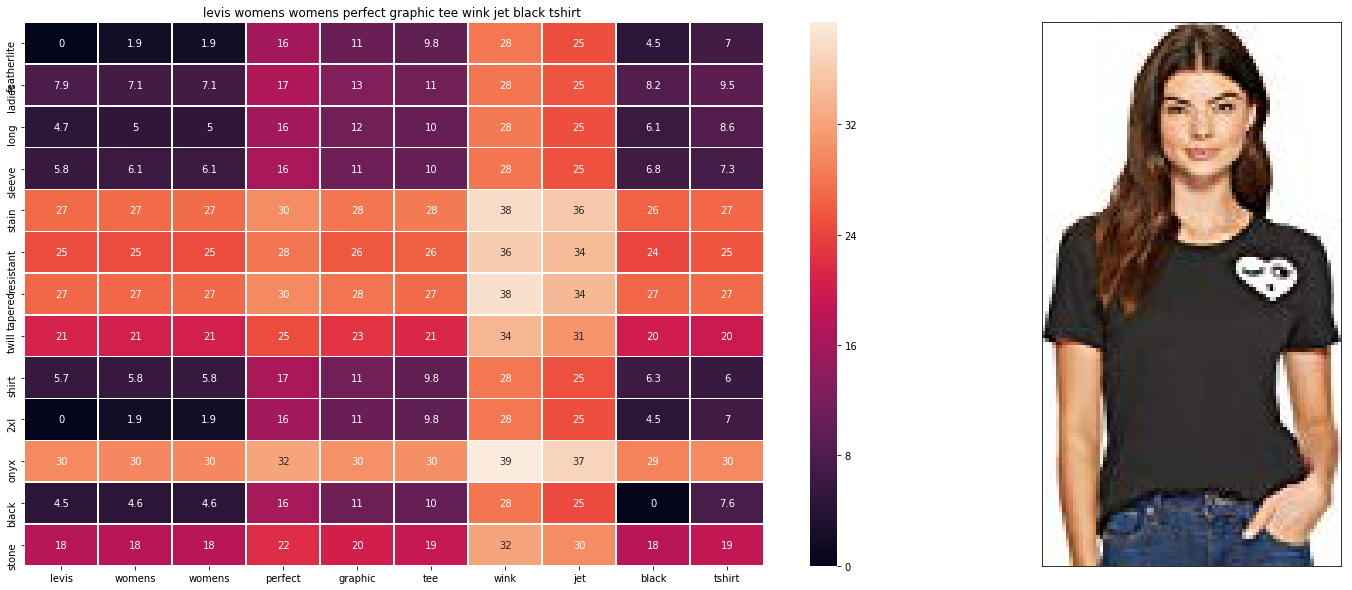

ASIN of the product : B072L2HS3V
Brand of the product : Levi's® Womens
Title of the product : levis womens womens perfect graphic tee wink jet black tshirt 
Type of the product : SHIRT
Euclidean distance from input : 0.0


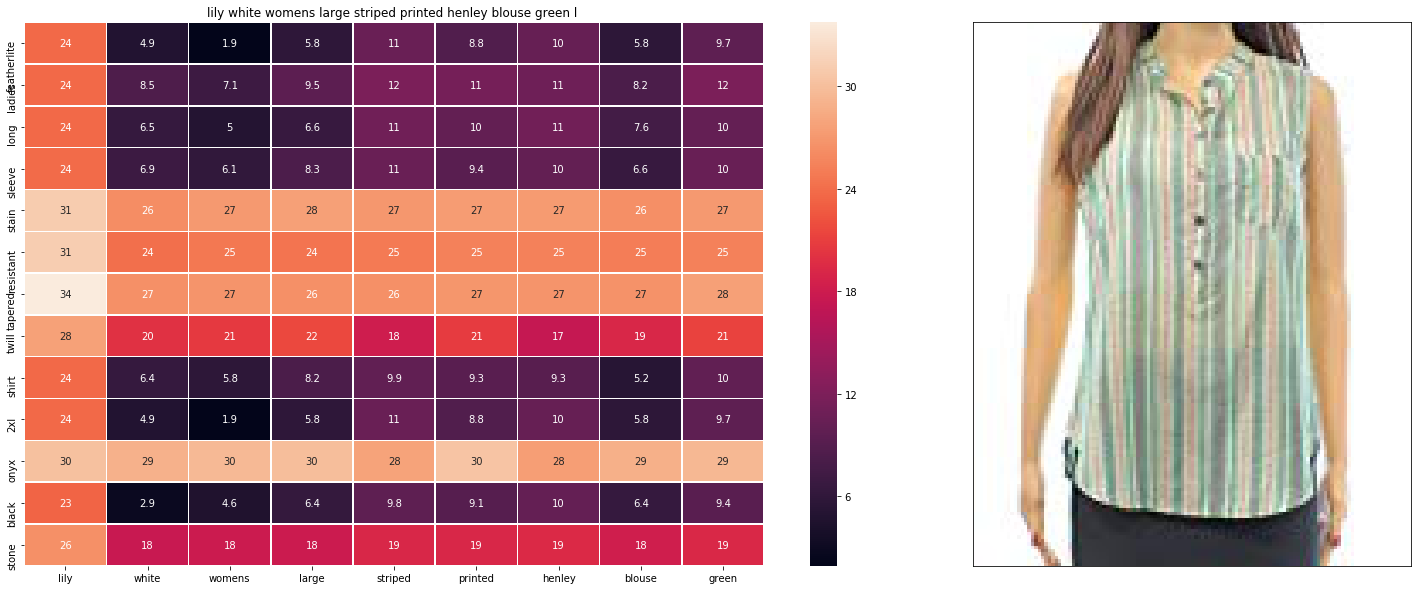

ASIN of the product : B0751N7PHJ
Brand of the product : Lily White
Title of the product : lily white womens large striped printed henley blouse green l 
Type of the product : SHIRT
Euclidean distance from input : 0.0


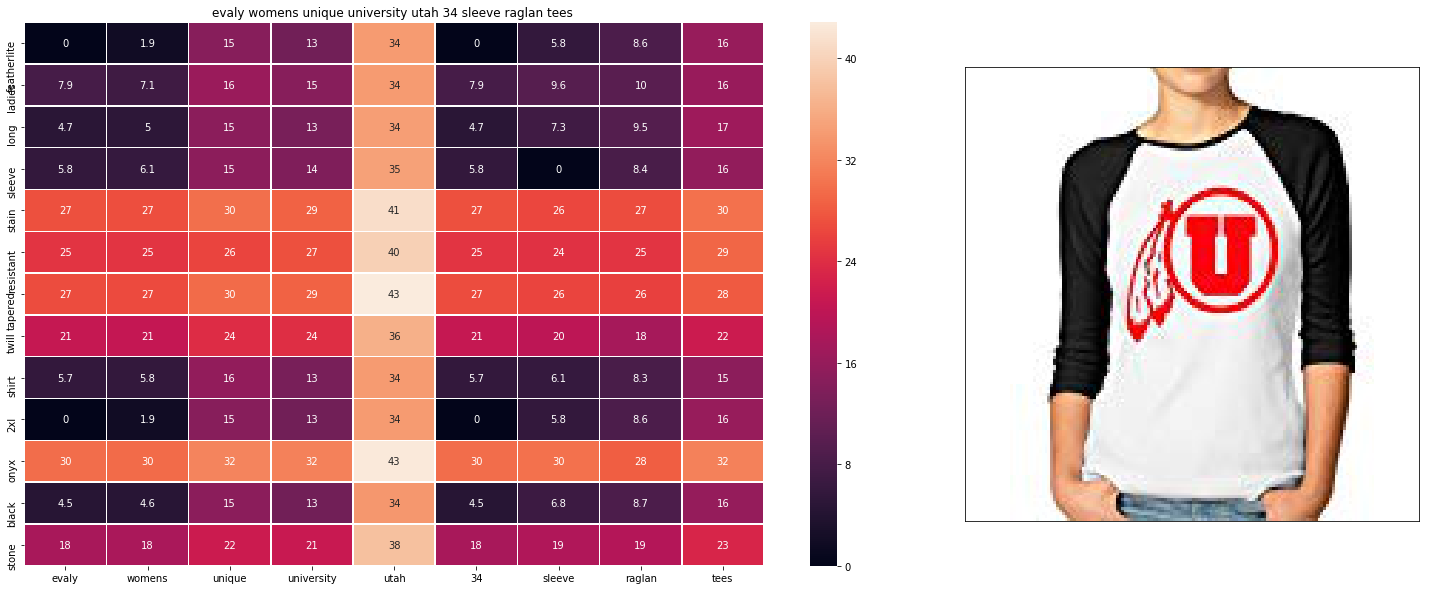

ASIN of the product : B01LJF0JSM
Brand of the product : EVALY Custom
Title of the product : evaly womens unique university utah 34 sleeve raglan tees 
Type of the product : SHIRT
Euclidean distance from input : 0.0


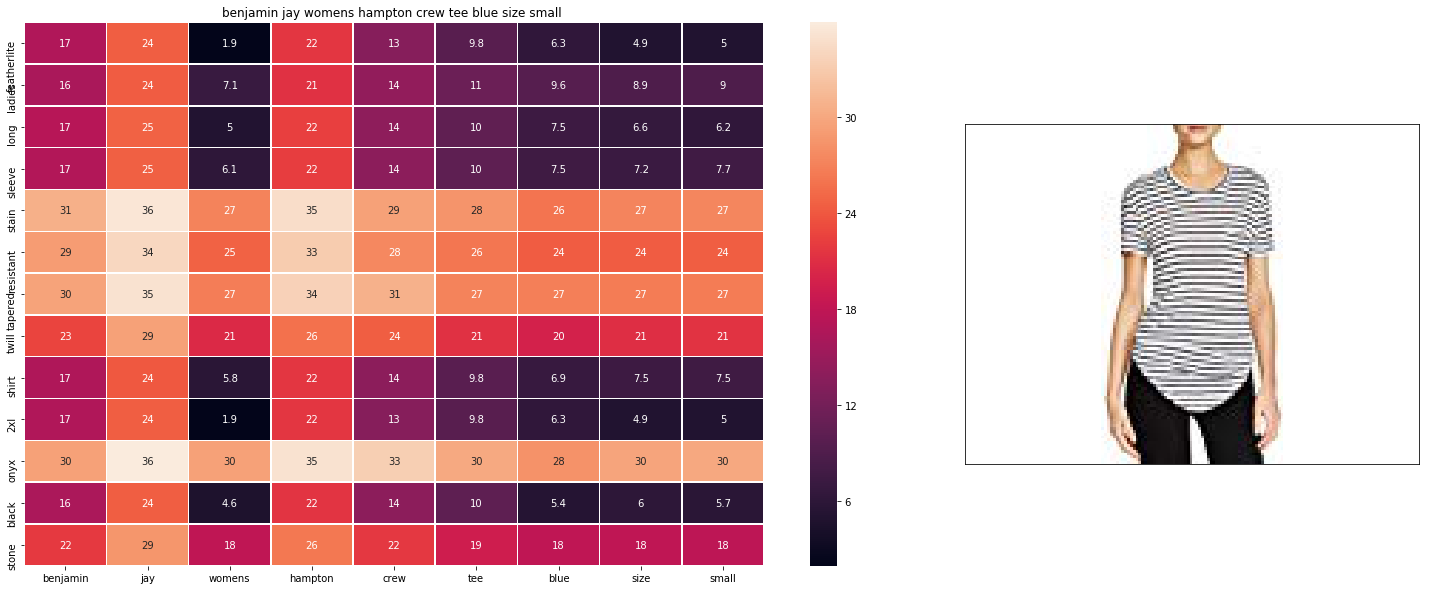

ASIN of the product : B071678657
Brand of the product : Benjamin Jay
Title of the product : benjamin jay womens hampton crew tee blue size small 
Type of the product : SHIRT
Euclidean distance from input : 0.0


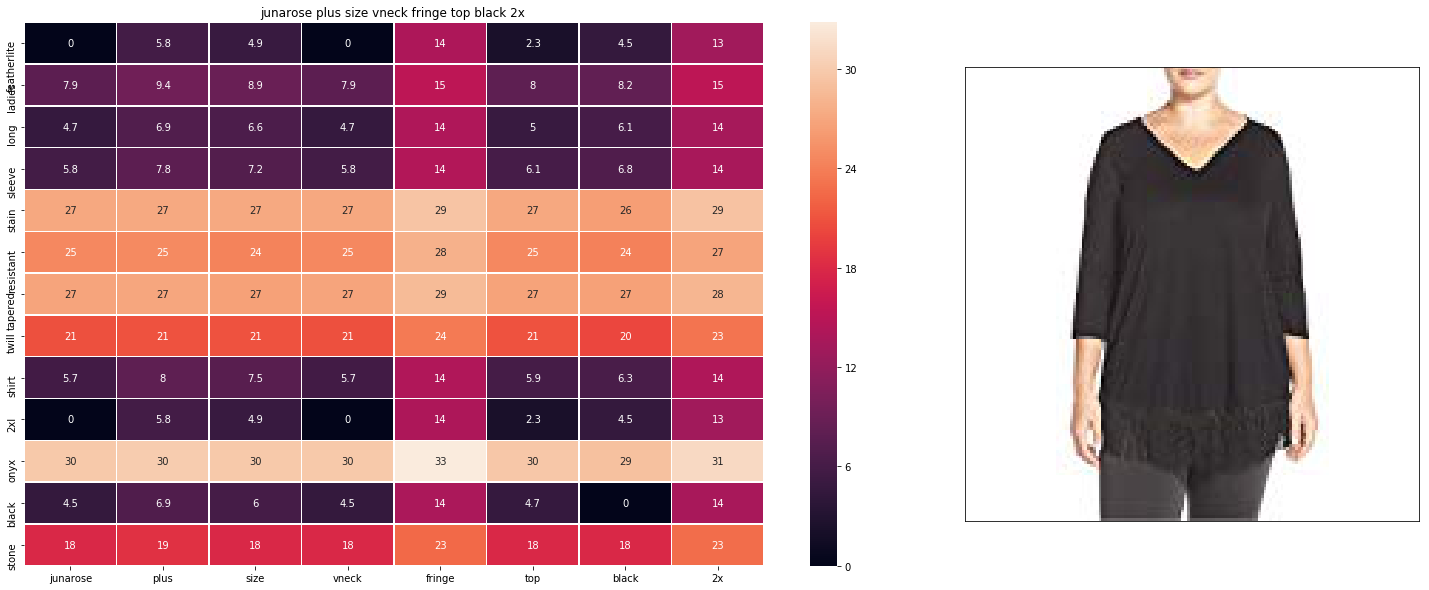

ASIN of the product : B00YJ28O8U
Brand of the product : Junarose
Title of the product : junarose plus size vneck fringe top black 2x 
Type of the product : SHIRT
Euclidean distance from input : 0.0


In [25]:
get_similar_products_cnn(12566, 0, 0, 0, 0, 100,  10)

OBSERVATIONS:
----------

1. We are seeing that the model works very well with the text features and is average with other features.
2. Giving more weights to type gave us extremely good results.